In [1]:
source("../wwa_model-fitting.R")
source("../00_model-fitting-dev/multivariate/model-fitting_multi-covariate.R")

# Modified log-likelihood function

In [2]:
ns_loglik <- function(pars, cov, x, dist, fittype) {

    effect <- rowSums(sapply(names(cov), function(cnm) pars[paste0("alpha_",cnm)] * cov[,cnm]))
    
    # compute nonstationary location & scale
    if(fittype == "fixeddisp") {
        const = exp(effect / pars["mu0"])
        loc = pars["mu0"] * const
        scale = pars["sigma0"] * const
    } else if(fittype == "shift") {
        loc = pars["mu0"] + effect
        scale = pars["sigma0"]
    } else if(fittype == "expshift") {
        loc = pars["mu0"] * exp(effect / pars["mu0"])
        scale = pars["sigma0"]
    } else {
        print(paste(fittype, "not implemented"))
        return()
    }

    # constrain variance to be strictly positive
    if(any(scale <= 0)) return(NA)
        
    # return negative log-likelihood
    if(dist == "norm") {
        return(-sum(dnorm(x, mean = loc, sd = scale, log = T)))
    } else if(dist == "gev") {
        shape = pars["shape"]
        return(-sum(devd(x, loc = loc, scale = scale, shape = shape, log = T)))
    } else {
        print(paste(dist, "not implemented"))
        return()
    }
}

#######################################################################################################

ns_pars <- function(mdl, fixed_cov = NA) {
    
    # if no covariate value given, evaluate at all covariate values
    if(is.na(unlist(fixed_cov)[1])) fixed_cov <- mdl$cov

    fixed_cov <- fixed_cov[,mdl$covnm, drop = F]
    
    # calculate the nonstationary parameter values
    pars <- mdl$par
    effect <- rowSums(matrix(sapply(names(fixed_cov), function(cnm) pars[paste0("alpha_",cnm)] * fixed_cov[,cnm]), nrow = nrow(fixed_cov)))
    
    if(mdl$type == "fixeddisp") {
        
        ns_const = exp(effect / pars["mu0"])
        loc = pars["mu0"] * ns_const
        scale = pars["sigma0"] * ns_const
        
    } else if(mdl$type == "shift") {
        loc = pars["mu0"] + effect
        scale = rep(pars["sigma0"], length(loc))
    } else if(mdl$type == "expshift") {
        loc = pars["mu0"] * exp(effect / pars["mu0"])
        scale = rep(pars["sigma0"], length(loc))
    } else {
        print(paste(mdl$type,"not implemented"))
        return()
    }
        
    # return the list of named parameters: location, scale, shape (if applicable)
    if("shape" %in% names(pars)) {
        return(lapply(list("loc" = loc, "scale" = scale, "shape" = rep(pars["shape"], length(scale))), unname))
    } else {
        return(lapply(list("loc" = loc, "scale" = scale), unname))
    }
}

#######################################################################################################
                                    
plot_covtrend <- function(mdl, xcov, fixed_cov = NA, ci_cov = NA, ev, xlim, ylim = NA, xlab = NA, ylab = NA,
                          legend_pos = "topleft", main = "", seed = 42, nsamp = 500, lwd = 3) {

    if(is.na(xlab)) { xlab <- toupper(xcov)}
    if(is.na(ylab)) { ylab <- mdl$varnm}
    if(missing(ev)) { ev <- mdl$ev }
    
    x <- mdl$cov[,xcov]
    o <- order(x)
    y <- x[which(mdl$x == ev)]

    if(is.na(ylim[1])) { ylim <- range(pretty(mdl$x)) }

    if(missing(xlim)) {
        if(is.na(unlist(ci_cov)[1])) {
            # can't plot confidence intervals so set nsamp to NA
            nsamp <- NA
            xlim <- range(x)
        } else {
            xlim <- range(c(ci_cov[,xcov]), x)
        }
    }
    
    plot(x, mdl$x, pch = 20, main = main, xlab = "", ylab = "", ylim = ylim, xlim = xlim,
         col = adjustcolor("black", alpha = 0.6))
    mtext(xlab, side = 1, line = 2.5, cex = par("cex"))
    mtext(ylab, side = 2, line = 2.5, cex = par("cex"))

    points(y, ev, col = "magenta", lwd = 2, pch = 0)

    # trend lines
    lines(x[o], ns_pars(mdl, fixed_cov = fixed_cov)$loc[o], lwd = 3, col = "black", lty = 1)
    lines(x[o], eff_return_level(mdl, 6, fixed_cov = fixed_cov)[o], col = "blue", lwd = 3, lty = 1)
    lines(x[o], eff_return_level(mdl, 40, fixed_cov = fixed_cov)[o], col = "blue", lwd = 2, lty = 1)
    
    # get confidence interval for mu' (if not required, set ci_cov to NA)
    if(!is.na(nsamp)) {
        mdl_df <- mdl$data
        set.seed(seed)
        mu_ci <- apply(sapply(1:nsamp, function(i) {
            boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
            tryCatch({
                boot_mdl <- refit(mdl, boot_df)
                ns_pars(boot_mdl, fixed_cov = ci_cov)$loc
            }, error = function(cond) {return(rep(NA, nrow(ci_cov)))})
        }), 1, quantile, c(0.025, 0.975), na.rm = T)
        
        # confidence interval & markers for mu' at factual & counterfactual covariates
        segments(x0 = ci_cov[,xcov], y0 = mu_ci["2.5%",], y1 = mu_ci["97.5%",], lwd = 3, col = "red3", lend = 1)
        # matplot(ci_cov[,"gmst"], t(mu_ci), pch = 3, add = T, col = "red3") # line ends: not very elegant, so removed for now
        points(ci_cov[,xcov], ns_pars(mdl, fixed_cov = ci_cov)$loc, pch = "_", col = "red3", lwd = 2)
    }

    # add legend
    legend(legend_pos, legend = c("location", "1-in-6-year event", "1-in-40-year event"), lty = 1, col = c("black", "blue", "blue"), lwd = c(2,2,1))
}

---
# Create DJF Nino time series

In [3]:
# load detrended Nino data
nino = read.csv("../10_misc/detrended_nino34/nino34_det.csv", col.names = c("month", "nino"))

# create dummy value for Feb 2024
nino_jan <- nino$nino[substr(nino$month,6,7) == "01"]
nino_feb <- nino$nino[substr(nino$month,6,7) == "02"]
nino$nino[nino$month == "2024-02-15"] <- nino$nino[nino$month == "2024-01-15"] + mean(nino_feb - nino_jan, na.rm = T)

# get three-month running mean
nino$nino <- filter(nino$nino, rep(1/3, 3), sides = 1)

# select February only (=DJF running mean) & label years
nino <- nino[substr(nino$month,6,7) == "02",]
nino$year <- substr(nino$month,1,4)

In [4]:
write.csv(nino[-1,c("year", "nino")], "nino_djf.csv", row.names = F)

---
# Load necessary data

In [3]:
# load GMST & relabel to cross zero at 24
gmst = read.table("gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# load precip data & relabel so that Feb 2024 event is labelled as 2024
pr = read.table("pr.dat", col.names = c("year", "pr"))
pr$year <- pr$year + 1

In [4]:
# load detrended Nino data
nino = read.csv("../10_misc/detrended_nino34/nino34_det.csv", col.names = c("month", "nino"))

# create dummy value for Feb 2024
nino_jan <- nino$nino[substr(nino$month,6,7) == "01"]
nino_feb <- nino$nino[substr(nino$month,6,7) == "02"]
nino$nino[nino$month == "2024-02-15"] <- nino$nino[nino$month == "2024-01-15"] + mean(nino_feb - nino_jan, na.rm = T)

# get three-month running mean
nino$nino <- filter(nino$nino, rep(1/3, 3), sides = 1)

# select February only (=DJF running mean) & label years
nino <- nino[substr(nino$month,6,7) == "02",]
nino$year <- substr(nino$month,1,4)

In [5]:
df <- merge(merge(gmst, nino[,c("year", "nino")]), pr)

pr_2024 <- df$pr[df$year == 2024]
gmst_2024 <- df$gmst[df$year == 2024]
nino_2024 <- df$nino[df$year == 2024]

# Test model with GMST only

In [12]:
mdl_shift <- fit_ns("gev", "shift", df, "pr", c("gmst"))
mdl_scale <- fit_ns("gev", "fixeddisp", df, "pr", c("gmst"))
mdl_eshift <- fit_ns("gev", "expshift", df, "pr", c("gmst"))

In [13]:
cat("Shift:",aic(mdl_shift),"\n")
cat("Scale:",aic(mdl_scale),"\n")
cat("Exp-shift:",aic(mdl_eshift),"\n")

Shift: 529.5855 
Scale: 532.0998 
Exp-shift: 529.9218 


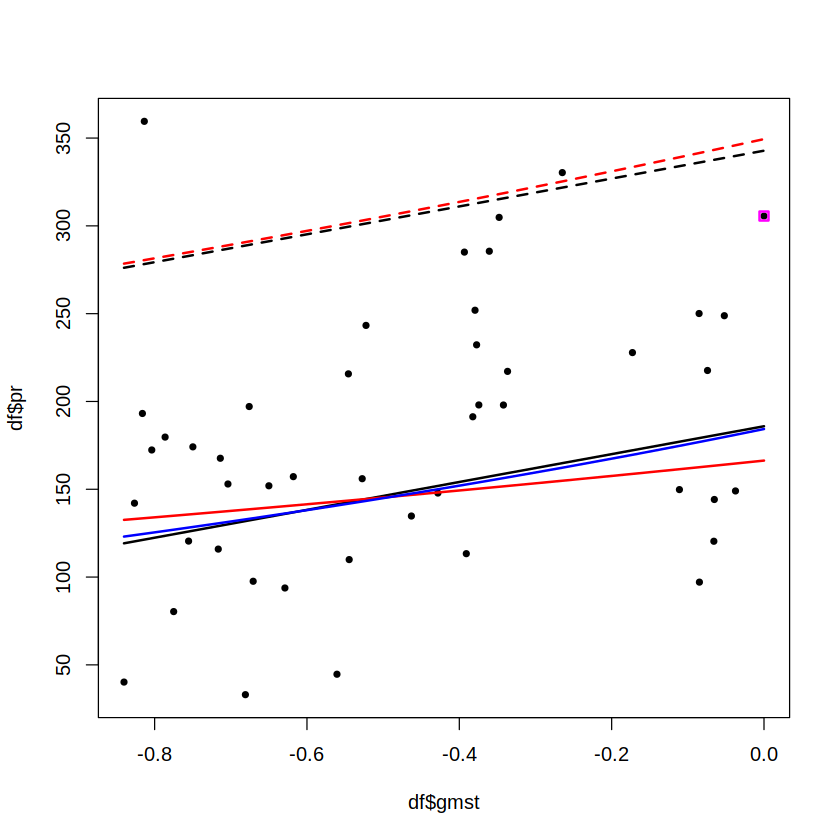

In [14]:
o <- order(df$gmst)
plot(df$gmst, df$pr, pch = 20)

points(df[df$year == 2024,c("gmst", "pr")], col = "magenta", pch = 0, lwd = 2)
lines(df$gmst[o], ns_pars(mdl_shift)$loc[o], lwd = 2)
lines(df$gmst[o], ns_pars(mdl_scale)$loc[o], col = "red", lwd = 2)
lines(df$gmst[o], ns_pars(mdl_eshift)$loc[o], col = "blue", lwd = 2)

lines(df$gmst[o], eff_return_level(mdl_shift, 20)[o], lwd = 2, lty = 2)
lines(df$gmst[o], eff_return_level(mdl_scale, 20)[o], lwd = 2, lty = 2, col = "red")
# lines(df$gmst[o], eff_return_level(mdl_eshift, 20)[o], col = "blue", lwd = 2)

In [15]:
# similar return periods regardless of model used
return_period(mdl_shift, pr_2024, fixed_cov = data.frame("gmst" = gmst_2024))
return_period(mdl_scale, pr_2024, fixed_cov = data.frame("gmst" = gmst_2024))
return_period(mdl_eshift, pr_2024, fixed_cov = data.frame("gmst" = gmst_2024))

[1] 8.977871

[1] 8.862669

[1] 9.483055

# Test model with GMST & Nino3.4

In [16]:
mdl_shift <- fit_ns("gev", "shift", df, "pr", c("gmst", "nino"))
mdl_scale <- fit_ns("gev", "fixeddisp", df, "pr", c("gmst", "nino"))
mdl_eshift <- fit_ns("gev", "expshift", df, "pr", c("gmst", "nino"))

In [17]:
cat("Shift:",aic(mdl_shift),"\n")
cat("Scale:",aic(mdl_scale),"\n")
cat("Exp-shift:",aic(mdl_eshift),"\n")

Shift: 521.9469 
Scale: 527.1494 
Exp-shift: 523.4725 


In [18]:
# similar return periods for exponential & linear shift - scale has inflated return period
cat("Shift:",return_period(mdl_shift, pr_2024, fixed_cov = data.frame("gmst" = gmst_2024, "nino" = nino_2024)),"\n")
cat("Scale:",return_period(mdl_scale, pr_2024, fixed_cov = data.frame("gmst" = gmst_2024, "nino" = nino_2024)),"\n")
cat("Exp-shift:",return_period(mdl_eshift, pr_2024, fixed_cov = data.frame("gmst" = gmst_2024, "nino" = nino_2024)),"\n")

Shift: 27.05939 
Scale: 37.13671 
Exp-shift: 29.62764 


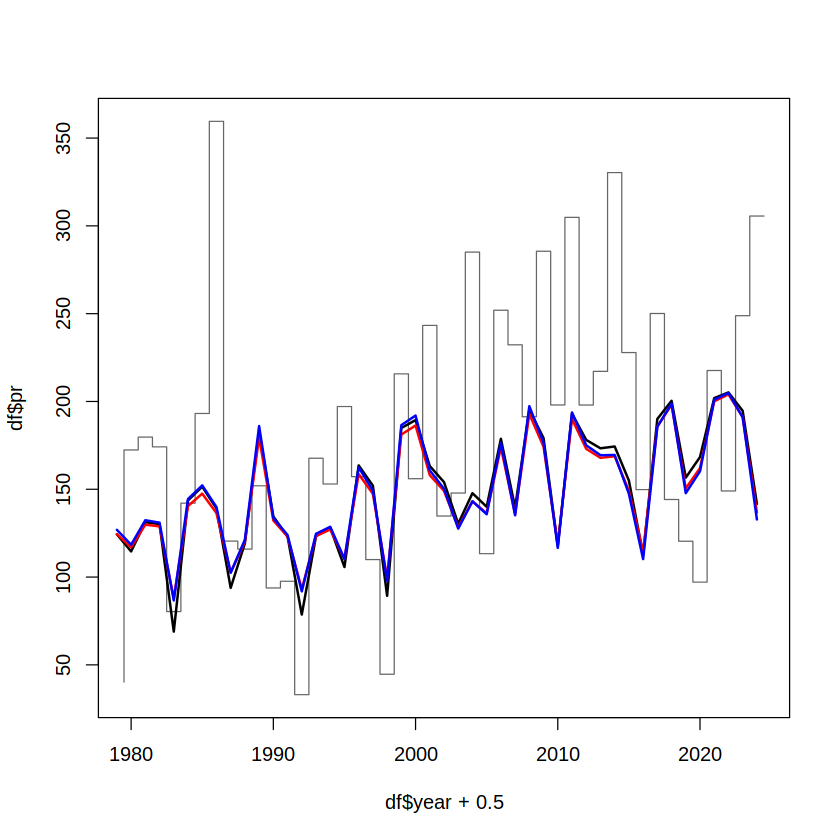

In [19]:
plot(df$year+0.5, df$pr, type = "S", col = adjustcolor("black", 0.6))
lines(df$year, ns_pars(mdl_shift)$loc, lwd = 2)
lines(df$year, ns_pars(mdl_scale)$loc, lwd = 2, col = "red")
lines(df$year, ns_pars(mdl_eshift)$loc, lwd = 2, col = "blue")

## Something's missing...

In [20]:
# still looks like there's something missing from the model...
df$res <- df$pr - ns_pars(mdl_shift)$loc

In [ ]:
amo = read.csv("../10_misc/detrended_nino34/amo.csv", col.names = c("year", "amo"))
df <- merge(df, amo)

In [ ]:
cor(df$gmst, df$amo)

In [32]:
cor(merge(gmst, amo))["gmst", "amo"]

[1] 0.128278

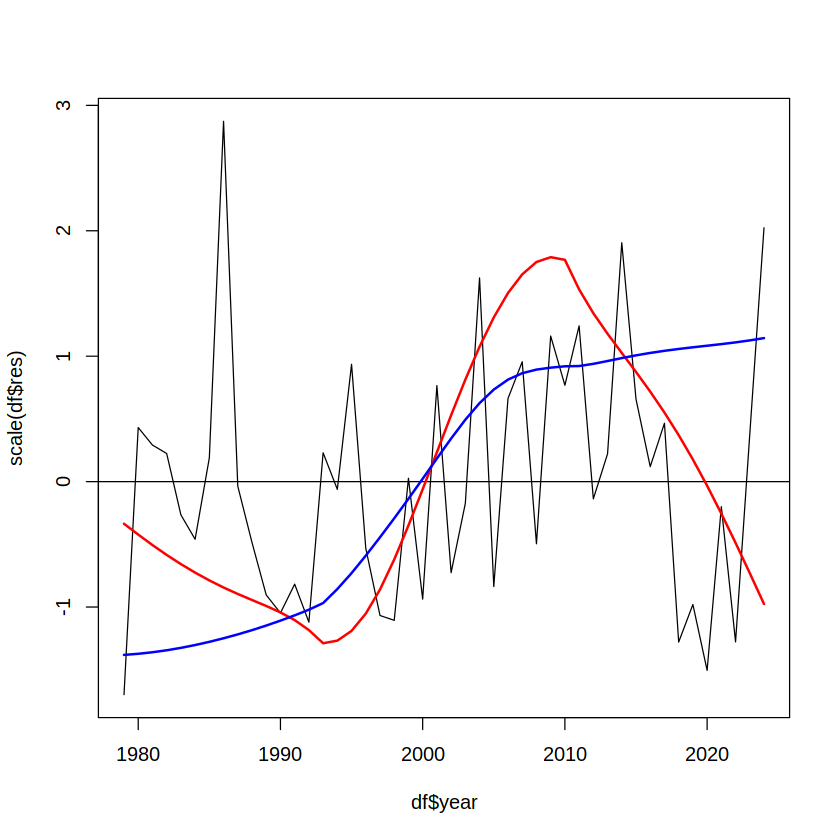

In [16]:
plot(df$year, scale(df$res), type = "l")
abline(h = 0)
lines(df$year, scale(lowess(df$res)$y), col = "red", lwd = 2)
lines(df$year, scale(lowess(df$amo)$y), col = "blue", lwd = 2)

# GMST + Nino3.4 + AMO

In [38]:
# load GMST & relabel to cross zero at 24
gmst = read.table("gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# load precip data & relabel so that Feb 2024 event is labelled as 2024
pr = read.table("pr.dat", col.names = c("year", "pr"))
pr$year <- pr$year + 1

# load detrended Nino data
nino = read.csv("../detrended_nino34/nino34_det.csv", col.names = c("month", "nino"))

# create dummy value for Feb 2024
nino_jan <- nino$nino[substr(nino$month,6,7) == "01"]
nino_feb <- nino$nino[substr(nino$month,6,7) == "02"]
nino$nino[nino$month == "2024-02-15"] <- nino$nino[nino$month == "2024-01-15"] + mean(nino_feb - nino_jan, na.rm = T)

# get three-month running mean
nino$nino <- filter(nino$nino, rep(1/3, 3), sides = 1)

# select February only (=DJF running mean) & label years
nino <- nino[substr(nino$month,6,7) == "02",]
nino$year <- substr(nino$month,1,4)

amo = read.csv("../detrended_nino34/amo.csv", col.names = c("year", "amo"))
df <- merge(merge(merge(gmst, nino[,c("year", "nino")]), amo), pr)
amo_2024 <- amo$amo[amo$year == 2024]

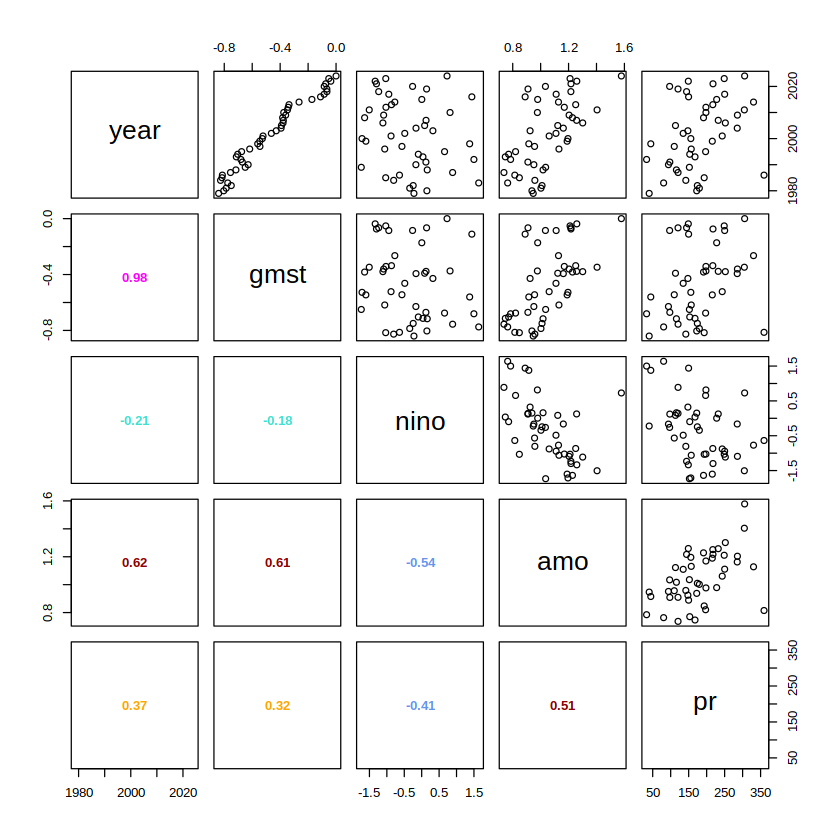

In [26]:
pairs(df, lower.panel = panel.cor)

In [ ]:
models <- list("gmst" = fit_ns("gev", "shift", df, "pr", c("gmst")),
               "amo" = fit_ns("gev", "shift", df, "pr", c("amo")),
               "gmst+nino" = fit_ns("gev", "shift", df, "pr", c("gmst", "nino")),
               "gmst+amo" = fit_ns("gev", "shift", df, "pr", c("gmst", "amo")),
               "gmst+nino+amo" = fit_ns("gev", "shift", df, "pr", c("gmst", "nino", "amo")))

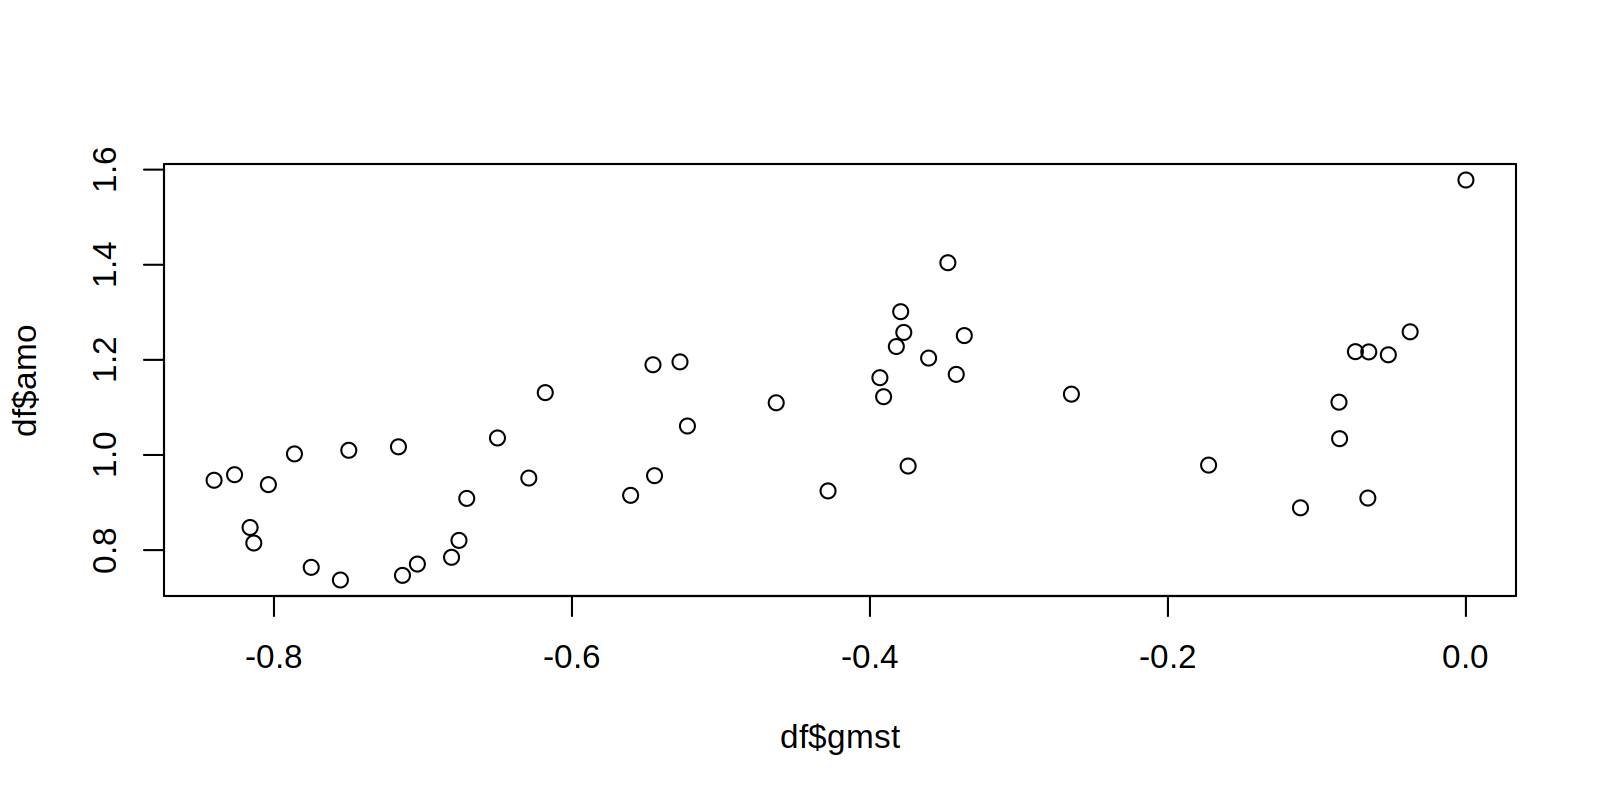

In [158]:
plot(df$gmst, df$amo)

In [100]:
sapply(models, aic)

gmst           amo     gmst+nino      gmst+amo gmst+nino+amo 
     529.5855      526.7581      521.9469      522.6561      523.0849

In [101]:
# return period is much lower when AMO is included. MUCH lower.
sapply(models, return_period)[df$year == 2024,]

gmst           amo     gmst+nino      gmst+amo gmst+nino+amo 
     8.977871      8.208153     27.059393      3.713626     19.141226

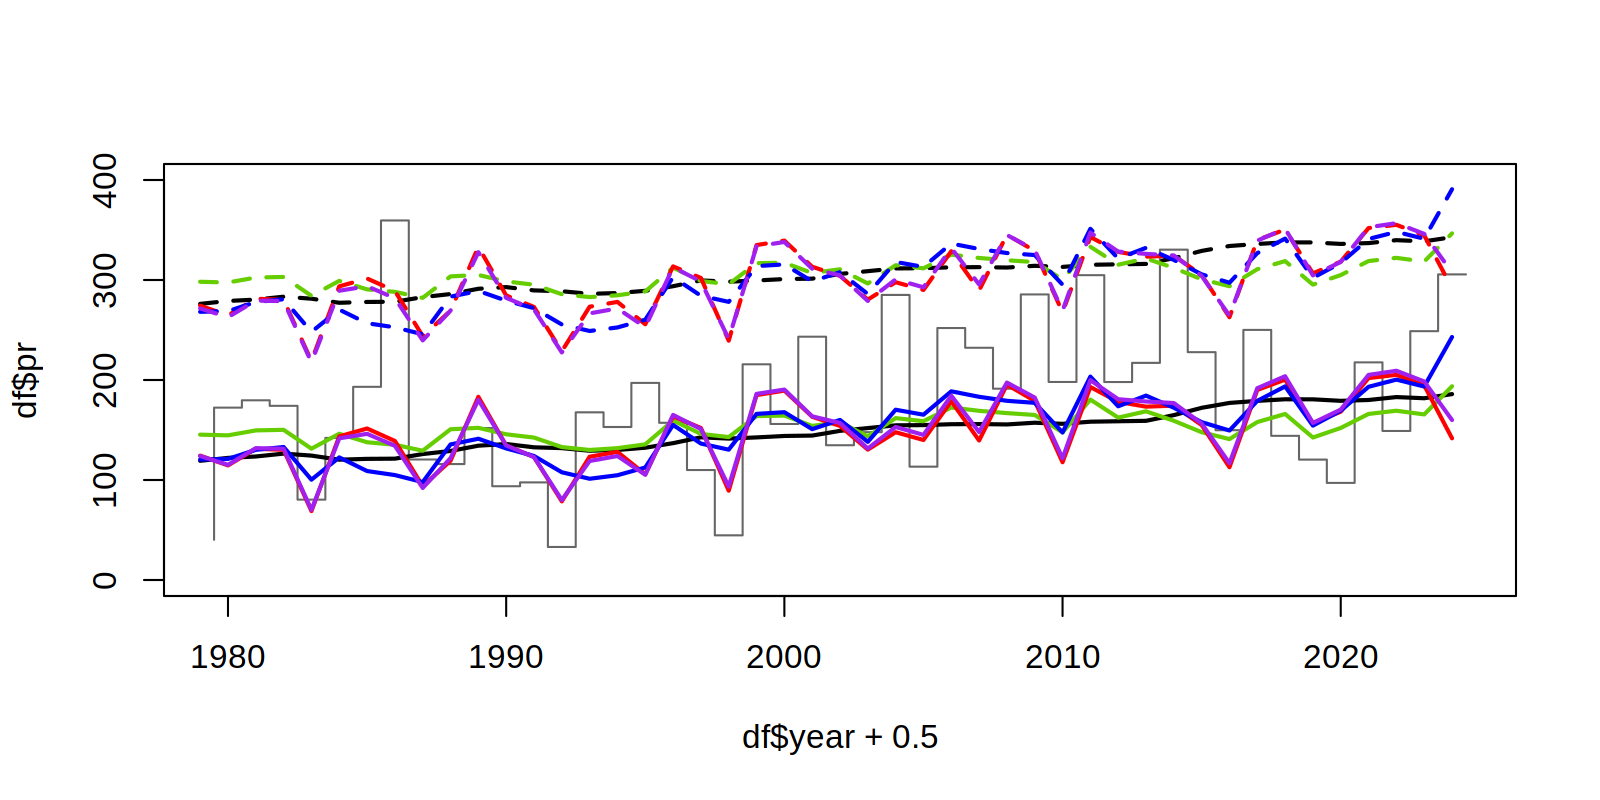

In [105]:
plot(df$year+0.5, df$pr, type = "S", col = adjustcolor("black", 0.6), ylim = c(0,400))
lines(df$year, ns_pars(models[["gmst"]])$loc, lwd = 2)
lines(df$year, ns_pars(models[["amo"]])$loc, lwd = 2, col = "chartreuse3")
lines(df$year, ns_pars(models[["gmst+nino"]])$loc, lwd = 2, col = "red")
lines(df$year, ns_pars(models[["gmst+amo"]])$loc, lwd = 2, col = "blue")
lines(df$year, ns_pars(models[["gmst+nino+amo"]])$loc, lwd = 2, col = "purple")

lines(df$year, eff_return_level(models[["gmst"]], 20), lwd = 2, lty = 2)
lines(df$year, eff_return_level(models[["amo"]], 20), lwd = 2, lty = 2, col = "chartreuse3")
lines(df$year, eff_return_level(models[["gmst+nino"]], 20), lwd = 2, lty = 2, col = "red")
lines(df$year, eff_return_level(models[["gmst+amo"]], 20), lwd = 2, lty = 2, col = "blue")
lines(df$year, eff_return_level(models[["gmst+nino+amo"]], 20), lwd = 2, lty = 2, col = "purple")

In [ ]:
boot_res <- sapply(models, function(mdl) {
    boot_ci(mdl, nsamp = 500,
       cov = data.frame("gmst" = gmst_2024, "nino" = nino_2024, "amo" = amo_2024)[,mdl$covnm,drop = F],
       cov_cf = data.frame("gmst" = gmst_2024 - 1.2, "nino" = nino_2024, "amo" = amo_2024)[,mdl$covnm,drop = F])
})

In [ ]:
# alpha_gmst <- abind(lapply(boot_res, "[", "alpha_gmst",), along = 0)
rp <- abind(lapply(boot_res, "[", "return_period",), along = 0)
dI <- abind(lapply(boot_res, "[", "dI_rel",), along = 0)

In [141]:
res_tables <- sapply(c("alpha_gmst", "alpha_nino", "alpha_amo", "return_period", "dI_abs"), function(r) {
    t(sapply(boot_res, function(res) {
        if (r %in% rownames(res)) { return(res[r,]) } else { return(setNames(rep(NA, ncol(res)), c("bestimate", "2.5%", "97.5%"))) }
    }))
}, simplify = F)

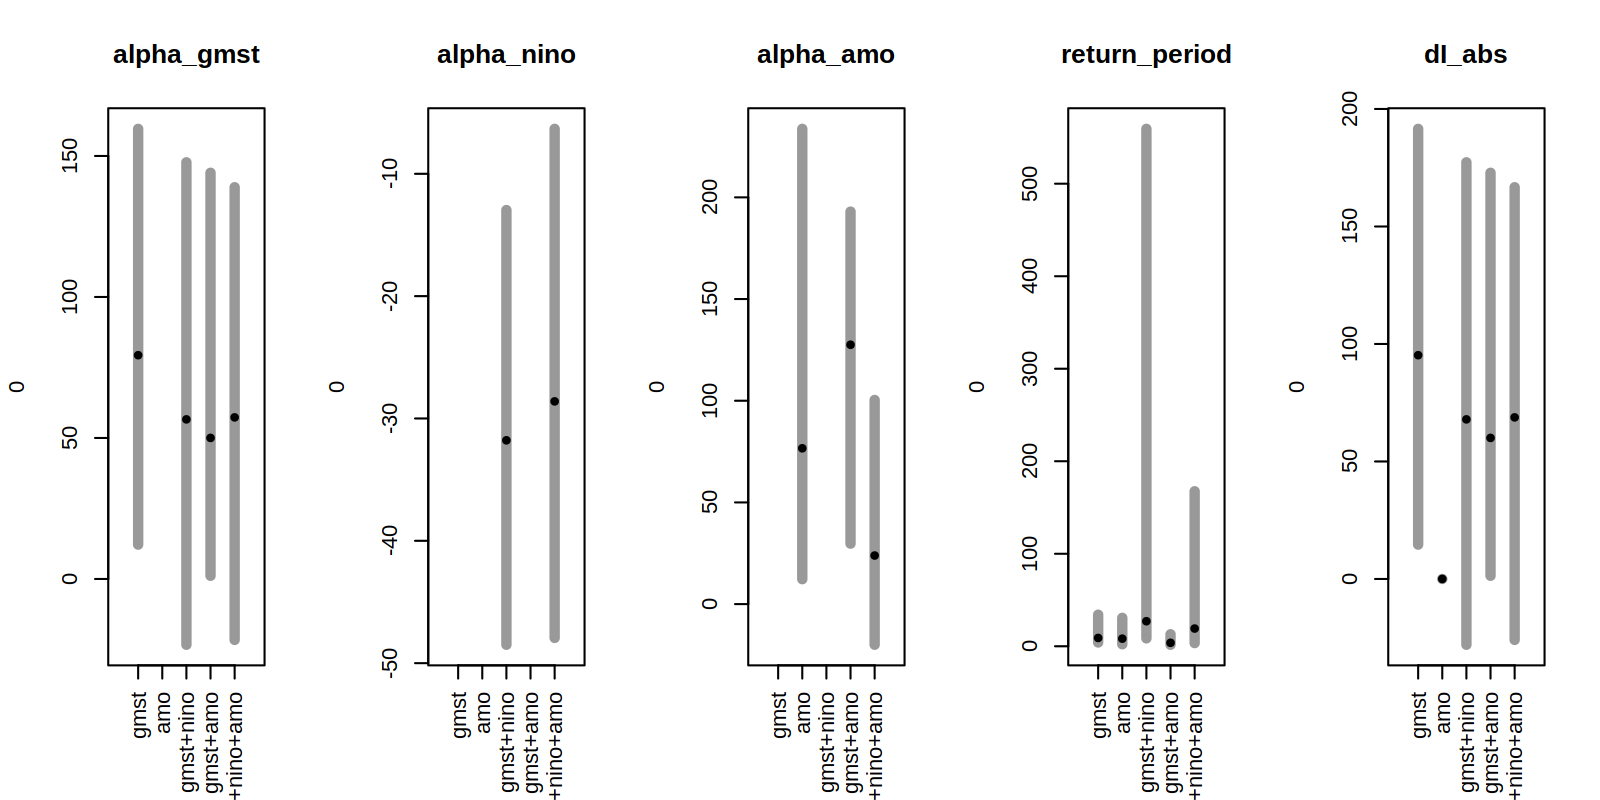

In [145]:
prep_window(c(1,2)); par(mfrow = c(1,length(res_tables)))
n <- length(models)

for (r in names(res_tables)) {
    res <- res_tables[[r]]
    plot(0, type = "n", ylim = range(res, na.rm = T), xlim = c(0,n+1), main = r, xaxt = "n", xlab = "")
    axis(1, at = 1:n, labels = names(boot_res), las = 2)
    segments(x0 = 1:n, y0 = res[,"2.5%"], y1 = res[,"97.5%"], lwd = 5, col = adjustcolor("black", alpha = 0.4))
    points(1:n, res[,"bestimate"], pch = 20)
}

# GMST + Nino3.4 + PDO

In [ ]:
# load GMST & relabel to cross zero at 24
gmst = read.table("gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# load precip data & relabel so that Feb 2024 event is labelled as 2024
pr = read.table("pr.dat", col.names = c("year", "pr"))
pr$year <- pr$year + 1

# load detrended Nino data
nino = read.csv("../detrended_nino34/nino34_det.csv", col.names = c("month", "nino"))

# create dummy value for Feb 2024
nino_jan <- nino$nino[substr(nino$month,6,7) == "01"]
nino_feb <- nino$nino[substr(nino$month,6,7) == "02"]
nino$nino[nino$month == "2024-02-15"] <- nino$nino[nino$month == "2024-01-15"] + mean(nino_feb - nino_jan, na.rm = T)

# get three-month running mean
nino$nino <- filter(nino$nino, rep(1/3, 3), sides = 1)

# select February only (=DJF running mean) & label years
nino <- nino[substr(nino$month,6,7) == "02",]
nino$year <- substr(nino$month,1,4)

In [75]:
pdo = read.csv("pdo.csv")
df <- merge(merge(merge(gmst, nino[,c("year", "nino")]), pdo), pr)

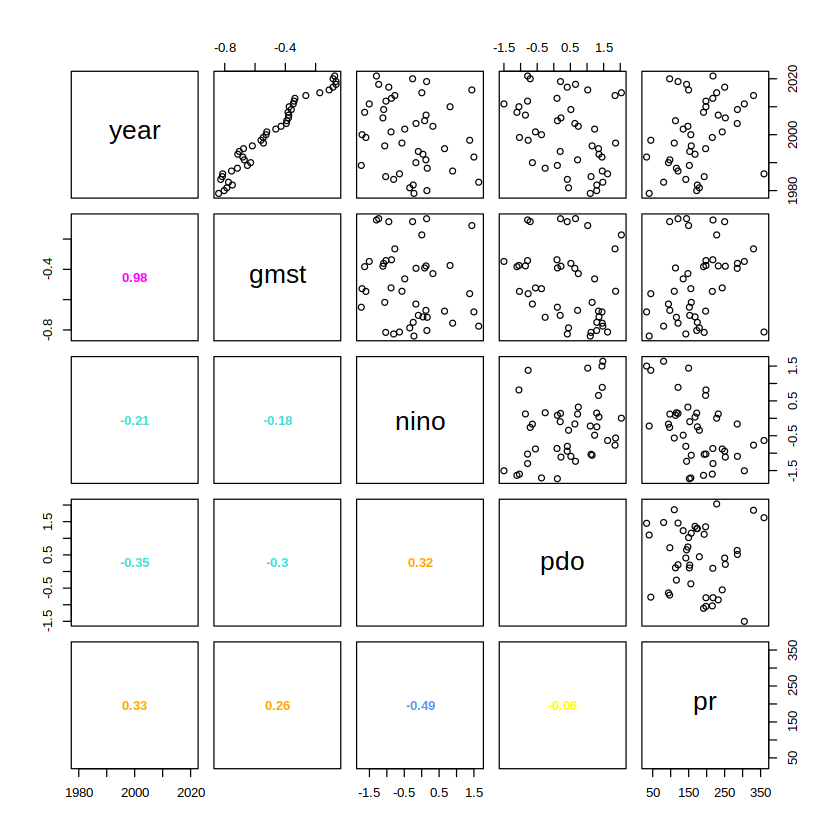

In [57]:
pairs(df, lower.panel = panel.cor)

In [79]:
models <- list("gmst" = fit_ns("gev", "shift", df, "pr", c("gmst")),
               "gmst+nino" = fit_ns("gev", "shift", df, "pr", c("gmst", "nino")),
               "gmst+pdo" = fit_ns("gev", "shift", df, "pr", c("gmst", "pdo")),
               "gmst+nino+pdo" = fit_ns("gev", "shift", df, "pr", c("gmst", "nino", "pdo")))

df$res <- df$pr - ns_pars(fit_ns("gev", "shift", df, "pr", c("gmst", "nino")))$loc

In [80]:
sapply(models, aic)

gmst     gmst+nino      gmst+pdo gmst+nino+pdo 
     495.6144      485.3154      497.7284      487.0375

In [60]:
# similar return periods for exponential & linear shift - scale has inflated return period
sapply(models, return_period)[df$year == 2024,]

gmst,gmst+nino,gmst+pdo,gmst+nino+pdo


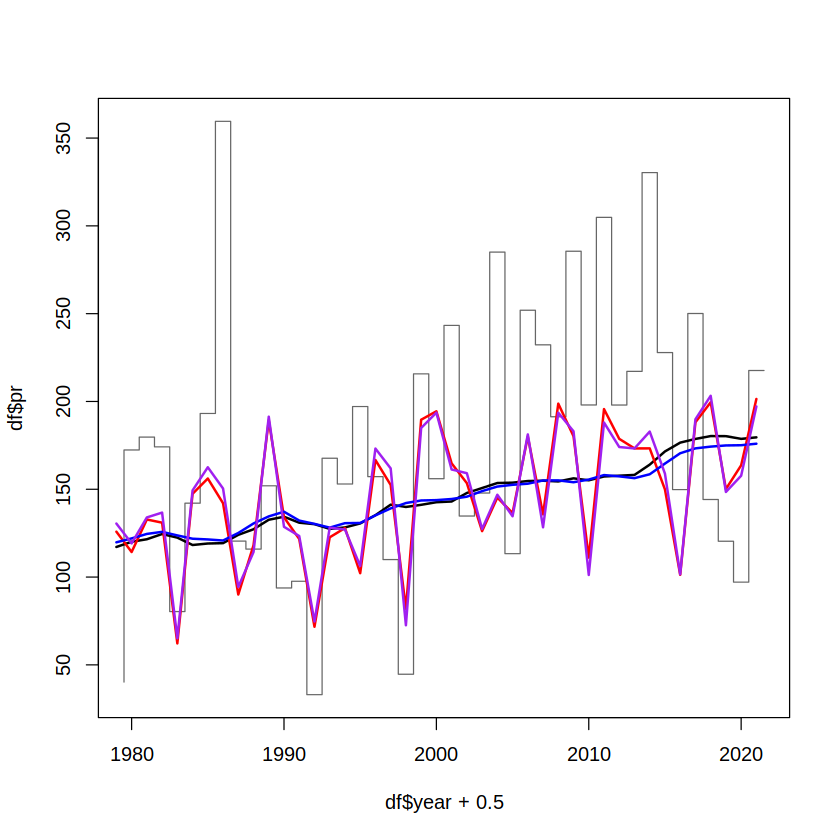

In [61]:
plot(df$year+0.5, df$pr, type = "S", col = adjustcolor("black", 0.6))
lines(df$year, ns_pars(models[["gmst"]])$loc, lwd = 2)
lines(df$year, ns_pars(models[["gmst+nino"]])$loc, lwd = 2, col = "red")
lines(df$year, ns_pars(models[["gmst+pdo"]])$loc, lwd = 2, col = "blue")
lines(df$year, ns_pars(models[["gmst+nino+pdo"]])$loc, lwd = 2, col = "purple")


# CHIRPS


In [12]:
# load GMST & relabel to cross zero at 24
gmst = read.table("gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# load precip data & relabel so that Feb 2024 event is labelled as 2024
pr = read.csv("chirps-rx5day.csv", col.names = c("year", "pr"))
pr$year <- pr$year + 1

# load detrended Nino data
nino = read.csv("../10_misc/detrended_nino34/nino34_det.csv", col.names = c("month", "nino"))

# create dummy value for Feb 2024
nino_jan <- nino$nino[substr(nino$month,6,7) == "01"]
nino_feb <- nino$nino[substr(nino$month,6,7) == "02"]
nino$nino[nino$month == "2024-02-15"] <- nino$nino[nino$month == "2024-01-15"] + mean(nino_feb - nino_jan, na.rm = T)

# get three-month running mean
nino$nino <- filter(nino$nino, rep(1/3, 3), sides = 1)

# select February only (=DJF running mean) & label years
nino <- nino[substr(nino$month,6,7) == "02",]
nino$year <- substr(nino$month,1,4)

# create single dataframe
df <- merge(merge(gmst, nino[,c("year", "nino")]), pr)

# pull out covariates
pr_2024 <- df$pr[df$year == 2024]
gmst_2024 <- df$gmst[df$year == 2024]
nino_2024 <- df$nino[df$year == 2024]

## Nonstationary models

In [13]:
mdl_shift <- fit_ns("gev", "shift", df, "pr", c("gmst"))
mdl_scale <- fit_ns("gev", "fixeddisp", df, "pr", c("gmst"))
mdl_eshift <- fit_ns("gev", "expshift", df, "pr", c("gmst"))

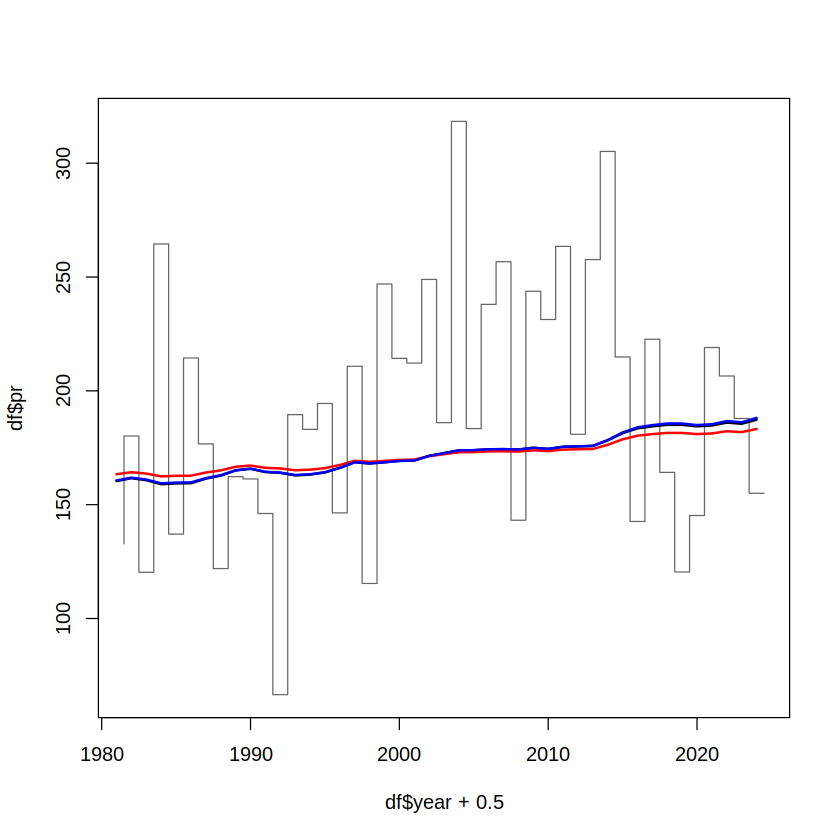

In [15]:
plot(df$year+0.5, df$pr, type = "S", col = adjustcolor("black", 0.6))
lines(df$year, ns_pars(mdl_shift)$loc, lwd = 2)
lines(df$year, ns_pars(mdl_scale)$loc, lwd = 2, col = "red")
lines(df$year, ns_pars(mdl_eshift)$loc, lwd = 2, col = "blue")

In [14]:
cat("Shift:",aic(mdl_shift),"\n")
cat("Scale:",aic(mdl_scale),"\n")
cat("Exp-shift:",aic(mdl_eshift),"\n")

Shift: 480.0451 
Scale: 480.4283 
Exp-shift: 480.1655 


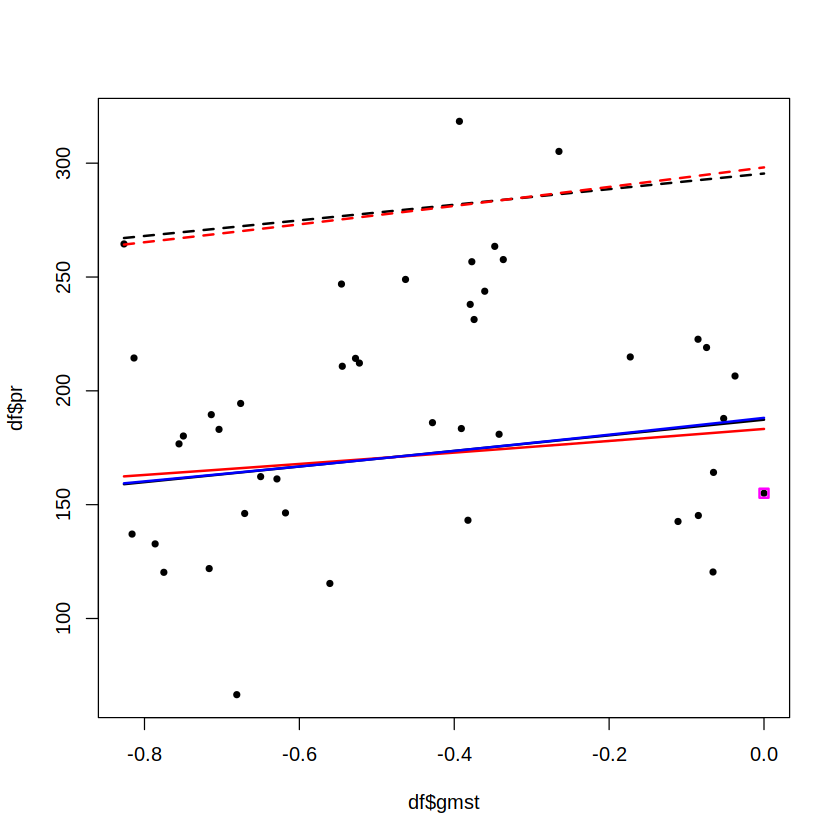

In [16]:
o <- order(df$gmst)
plot(df$gmst, df$pr, pch = 20)

points(df[df$year == 2024,c("gmst", "pr")], col = "magenta", pch = 0, lwd = 2)
lines(df$gmst[o], ns_pars(mdl_shift)$loc[o], lwd = 2)
lines(df$gmst[o], ns_pars(mdl_scale)$loc[o], col = "red", lwd = 2)
lines(df$gmst[o], ns_pars(mdl_eshift)$loc[o], col = "blue", lwd = 2)

lines(df$gmst[o], eff_return_level(mdl_shift, 20)[o], lwd = 2, lty = 2)
lines(df$gmst[o], eff_return_level(mdl_scale, 20)[o], lwd = 2, lty = 2, col = "red")
# lines(df$gmst[o], eff_return_level(mdl_eshift, 20)[o], col = "blue", lwd = 2)

# MSWEP vs CHIRPS

In [14]:
# load GMST & relabel to cross zero at 24
gmst = read.table("gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# load precip data & relabel so that Feb 2024 event is labelled as 2024
chirps = read.csv("chirps-rx5day.csv", col.names = c("year", "chirps"))
chirps$year <- chirps$year + 1

mswep = read.table("pr.dat", col.names = c("year", "mswep"))
mswep$year <- mswep$year + 1

# load detrended Nino data
nino = read.csv("../10_misc/detrended_nino34/nino34_det.csv", col.names = c("month", "nino"))

# create dummy value for Feb 2024
nino_jan <- nino$nino[substr(nino$month,6,7) == "01"]
nino_feb <- nino$nino[substr(nino$month,6,7) == "02"]
nino$nino[nino$month == "2024-02-15"] <- nino$nino[nino$month == "2024-01-15"] + mean(nino_feb - nino_jan, na.rm = T)

# get three-month running mean
nino$nino <- filter(nino$nino, rep(1/3, 3), sides = 1)

# select February only (=DJF running mean) & label years
nino <- nino[substr(nino$month,6,7) == "02",]
nino$year <- substr(nino$month,1,4)

# create single dataframe
df <- merge(merge(merge(gmst, nino[,c("year", "nino")]), chirps), mswep)

# pull out covariates
gmst_2024 <- df$gmst[df$year == 2024]

# fit models
shift_chirps <- fit_ns("gev", "shift", df, "chirps", c("gmst"))
shift_mswep <- fit_ns("gev", "shift", df, "mswep", c("gmst"))

scale_chirps <- fit_ns("gev", "fixeddisp", df, "chirps", c("gmst"))
scale_mswep <- fit_ns("gev", "fixeddisp", df, "mswep", c("gmst"))

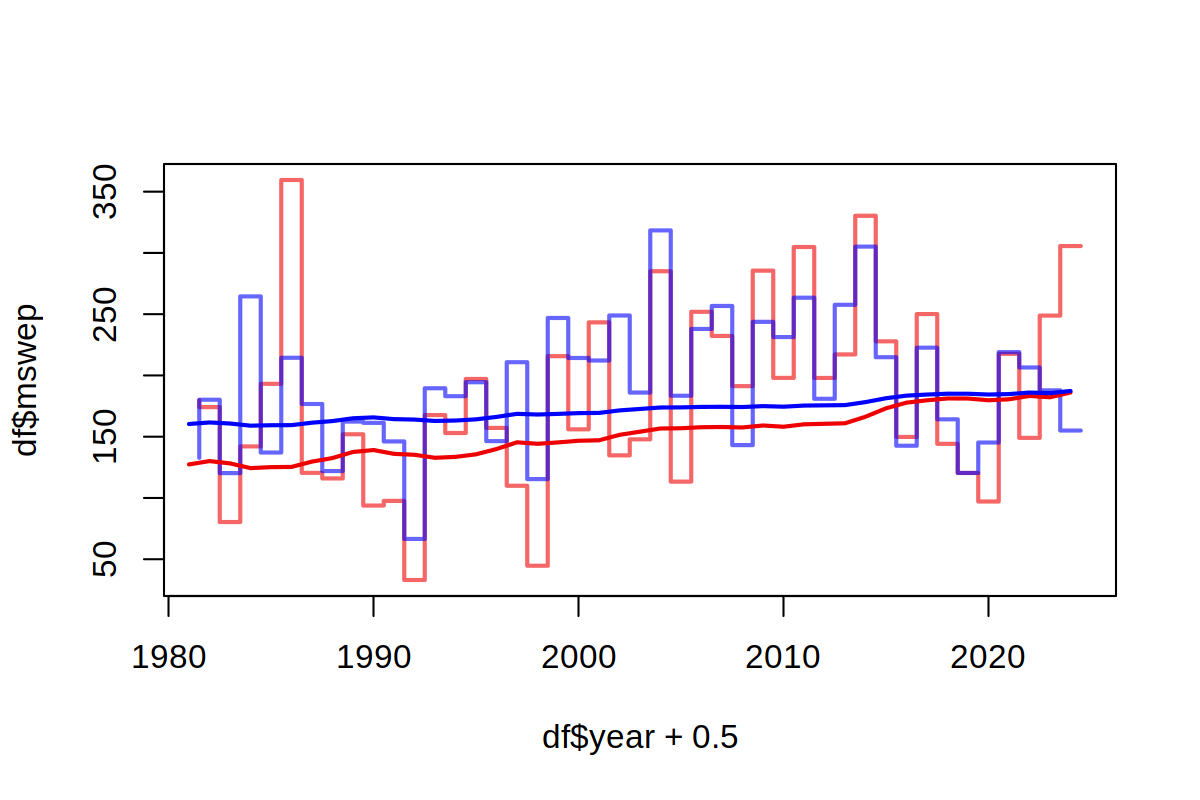

In [16]:
prep_window(c(1,1.5))

plot(df$year+0.5, df$mswep, type = "S", col = adjustcolor("red2", 0.6), lwd = 2)
lines(df$year+0.5, df$chirps, type = "S", col = adjustcolor("blue", 0.6), lwd = 2)

lines(df$year, ns_pars(shift_mswep)$loc, lwd = 2, col = "red2")
lines(df$year, ns_pars(shift_chirps)$loc, lwd = 2, col = "blue")

# lines(df$year, ns_pars(scale_mswep)$loc, lwd = 2, col = "red2", lty = 2)
# lines(df$year, ns_pars(scale_chirps)$loc, lwd = 2, col = "blue", lty = 2)

# Linear vs exponential shift

In [3]:
# load GMST & relabel to cross zero at 24
gmst = read.table("gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# load DJF Nino
nino <- read.csv("nino_djf.csv")

# extract fixed covariates
gmst_2024 <- gmst$gmst[gmst$year == 2024]
nino_2024 <- nino$nino[nino$year == 2024]

# load precip data & relabel so that Feb 2024 event is labelled as 2024
df <- merge(gmst, nino)
df <- merge(df, read.csv("ts/era5-rx5day.csv", col.names = c("year", "era5")))
df <- merge(df, read.csv("ts/chirps-rx5day.csv", col.names = c("year", "chirps")), all = T)
df <- merge(df, read.csv("ts/mswep-rx5day.csv", col.names = c("year", "mswep")), all = T)

datasets <- c("mswep", "chirps", "era5")

In [4]:
# fit the models
mdl_lshift <- sapply(datasets, function(ds) { fit_ns("gev", "shift", df[!is.na(df[,ds]),], ds, c("gmst")) }, simplify = F)
mdl_fd <- sapply(datasets, function(ds) { fit_ns("gev", "fixeddisp", df[!is.na(df[,ds]),], ds, c("gmst")) }, simplify = F)
mdl_eshift <- sapply(datasets, function(ds) { fit_ns("gev", "expshift", df[!is.na(df[,ds]),], ds, c("gmst")) }, simplify = F)

In [5]:
# plot results
prep_window(c(1,4)); par(mfrow = c(1,3))

png("fig/trend-fit-model-selection.png", width = 360*4, height = 360*1); par(mfrow = c(1,3), cex.main = 1.4); {
    for( ds in datasets ) {
        ds_df <- df[!is.na(df[,ds]),]
        plot_trend(mdl_lshift[[ds]], ylim = c(0,400), xlim = c(1950, 2024), main = ds)
    
        # lines(ds_df$year, lowess(ds_df[,ds])$y, col = "gold")
        
        lines(ds_df$year, ns_pars(mdl_fd[[ds]])$loc, col = "red4", lwd = 2)
        matplot(ds_df$year, eff_return_level(mdl_fd[[ds]], c(6,40)), col = "red4", lwd = c(2, 1), lty = 2, add = T, type = "l")
        
        lines(ds_df$year, ns_pars(mdl_eshift[[ds]])$loc, col = "forestgreen", lwd = 2)
        matplot(ds_df$year, eff_return_level(mdl_eshift[[ds]], c(6,40)), col = "forestgreen", lwd = c(2, 1), lty = 2, add = T, type = "l")

        legend("bottomleft", lty = 1, col = c("black", "red4", "forestgreen"), legend = c("Linear shift", "CC", "Exp. shift"))
    }
}; dev.off()


png 
  2

In [23]:
# plot results
prep_window(c(1,4)); par(mfrow = c(1,3))

png("fig/gmsttrend-fit-model-selection.png", width = 360*4, height = 360*1); par(mfrow = c(1,3), cex.main = 1.4); {
    for( ds in datasets ) {
        ds_df <- df[!is.na(df[,ds]),]
        o <- order(ds_df$gmst)
                              
        plot_covtrend(mdl_lshift[[ds]], xcov = "gmst", ylim = c(0,400), main = ds, xlim = c(-1.2, 0), nsamp = NA)
    
        # lines(ds_df$gmst[o], lowess(ds_df[o,ds])$y, col = "gold")
        
        lines(ds_df$gmst[o], ns_pars(mdl_fd[[ds]])$loc[o], col = "red4", lwd = 2)
        matplot(ds_df$gmst[o], eff_return_level(mdl_fd[[ds]], c(6,40))[o,], col = "red4", lwd = c(2, 1), lty = 2, add = T, type = "l")
        
        lines(ds_df$gmst[o], ns_pars(mdl_eshift[[ds]])$loc[o], col = "forestgreen", lwd = 2)
        matplot(ds_df$gmst[o], eff_return_level(mdl_eshift[[ds]], c(6,40))[o], col = "forestgreen", lwd = c(2, 1), lty = 2, add = T, type = "l")

        legend("bottomleft", lty = 1, col = c("black", "red4", "forestgreen"), legend = c("Linear shift", "CC", "Exp. shift"))
    }
}; dev.off()

png 
  2

In [128]:
cbind("lshift" = sapply(mdl_lshift, aic),
      "fixeddisp" = sapply(mdl_fd, aic),
      "eshift" = sapply(mdl_eshift, aic))

,lshift,fixeddisp,eshift
mswep,530.0526,532.1771,530.4738
chirps,479.5928,479.8561,479.9195
era5,831.8769,833.8124,831.6227


In [27]:
sapply(mdl_lshift, function(m) return_period(m)[length(m$x)])
sapply(mdl_eshift, function(m) return_period(m)[length(m$x)])
sapply(mdl_fd, function(m) return_period(m)[length(m$x)])

mswep   chirps     era5 
9.347074 1.902003 2.933801

mswep    chirps      era5 
10.416697  2.020798  2.900168

mswep   chirps     era5 
8.776370 1.885078 2.782807

# Linear vs exponential shift

In [3]:
# load GMST & relabel to cross zero at 24
gmst = read.table("gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# load DJF Nino
nino <- read.csv("nino_djf.csv")

# extract fixed covariates
gmst_2024 <- gmst$gmst[gmst$year == 2024]
nino_2024 <- nino$nino[nino$year == 2024]

# load precip data & relabel so that Feb 2024 event is labelled as 2024
df <- merge(gmst, nino)
df <- merge(df, read.csv("ts/era5-rx5day.csv", col.names = c("year", "era5")))
df <- merge(df, read.csv("ts/chirps-rx5day.csv", col.names = c("year", "chirps")), all = T)
df <- merge(df, read.csv("ts/mswep-rx5day.csv", col.names = c("year", "mswep")), all = T)

datasets <- c("mswep", "chirps", "era5")

In [4]:
# fit the models
mdl_lshift <- sapply(datasets, function(ds) { fit_ns("gev", "shift", df[!is.na(df[,ds]),], ds, c("gmst")) }, simplify = F)
mdl_fd <- sapply(datasets, function(ds) { fit_ns("gev", "fixeddisp", df[!is.na(df[,ds]),], ds, c("gmst")) }, simplify = F)
mdl_eshift <- sapply(datasets, function(ds) { fit_ns("gev", "expshift", df[!is.na(df[,ds]),], ds, c("gmst")) }, simplify = F)

In [5]:
# plot results
prep_window(c(1,4)); par(mfrow = c(1,3))

png("fig/trend-fit-model-selection.png", width = 360*4, height = 360*1); par(mfrow = c(1,3), cex.main = 1.4); {
    for( ds in datasets ) {
        ds_df <- df[!is.na(df[,ds]),]
        plot_trend(mdl_lshift[[ds]], ylim = c(0,400), xlim = c(1950, 2024), main = ds)
    
        # lines(ds_df$year, lowess(ds_df[,ds])$y, col = "gold")
        
        lines(ds_df$year, ns_pars(mdl_fd[[ds]])$loc, col = "red4", lwd = 2)
        matplot(ds_df$year, eff_return_level(mdl_fd[[ds]], c(6,40)), col = "red4", lwd = c(2, 1), lty = 2, add = T, type = "l")
        
        lines(ds_df$year, ns_pars(mdl_eshift[[ds]])$loc, col = "forestgreen", lwd = 2)
        matplot(ds_df$year, eff_return_level(mdl_eshift[[ds]], c(6,40)), col = "forestgreen", lwd = c(2, 1), lty = 2, add = T, type = "l")

        legend("bottomleft", lty = 1, col = c("black", "red4", "forestgreen"), legend = c("Linear shift", "CC", "Exp. shift"))
    }
}; dev.off()


png 
  2

In [23]:
# plot results
prep_window(c(1,4)); par(mfrow = c(1,3))

png("fig/gmsttrend-fit-model-selection.png", width = 360*4, height = 360*1); par(mfrow = c(1,3), cex.main = 1.4); {
    for( ds in datasets ) {
        ds_df <- df[!is.na(df[,ds]),]
        o <- order(ds_df$gmst)
                              
        plot_covtrend(mdl_lshift[[ds]], xcov = "gmst", ylim = c(0,400), main = ds, xlim = c(-1.2, 0), nsamp = NA)
    
        # lines(ds_df$gmst[o], lowess(ds_df[o,ds])$y, col = "gold")
        
        lines(ds_df$gmst[o], ns_pars(mdl_fd[[ds]])$loc[o], col = "red4", lwd = 2)
        matplot(ds_df$gmst[o], eff_return_level(mdl_fd[[ds]], c(6,40))[o,], col = "red4", lwd = c(2, 1), lty = 2, add = T, type = "l")
        
        lines(ds_df$gmst[o], ns_pars(mdl_eshift[[ds]])$loc[o], col = "forestgreen", lwd = 2)
        matplot(ds_df$gmst[o], eff_return_level(mdl_eshift[[ds]], c(6,40))[o], col = "forestgreen", lwd = c(2, 1), lty = 2, add = T, type = "l")

        legend("bottomleft", lty = 1, col = c("black", "red4", "forestgreen"), legend = c("Linear shift", "CC", "Exp. shift"))
    }
}; dev.off()

png 
  2

In [128]:
cbind("lshift" = sapply(mdl_lshift, aic),
      "fixeddisp" = sapply(mdl_fd, aic),
      "eshift" = sapply(mdl_eshift, aic))

,lshift,fixeddisp,eshift
mswep,530.0526,532.1771,530.4738
chirps,479.5928,479.8561,479.9195
era5,831.8769,833.8124,831.6227


In [27]:
sapply(mdl_lshift, function(m) return_period(m)[length(m$x)])
sapply(mdl_eshift, function(m) return_period(m)[length(m$x)])
sapply(mdl_fd, function(m) return_period(m)[length(m$x)])

mswep   chirps     era5 
9.347074 1.902003 2.933801

mswep    chirps      era5 
10.416697  2.020798  2.900168

mswep   chirps     era5 
8.776370 1.885078 2.782807

# Linear vs exponential shift (1980 onwards)

In [45]:
# load GMST & relabel to cross zero at 24
gmst = read.table("gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# load DJF Nino
nino <- read.csv("nino_djf.csv")

# extract fixed covariates
gmst_2024 <- gmst$gmst[gmst$year == 2024]
nino_2024 <- nino$nino[nino$year == 2024]

# load precip data & relabel so that Feb 2024 event is labelled as 2024
df <- merge(gmst, nino)
df <- merge(df, read.csv("ts/era5-rx5day.csv", col.names = c("year", "era5")))
df <- merge(df, read.csv("ts/chirps-rx5day.csv", col.names = c("year", "chirps")), all = T)
df <- merge(df, read.csv("ts/mswep-rx5day.csv", col.names = c("year", "mswep")), all = T)

df <- df[df$year >= 1980,]
datasets <- c("mswep", "chirps", "era5")

In [46]:
# fit the models
mdl_lshift <- sapply(datasets, function(ds) { fit_ns("gev", "shift", df[!is.na(df[,ds]),], ds, c("gmst")) }, simplify = F)
mdl_fd <- sapply(datasets, function(ds) { fit_ns("gev", "fixeddisp", df[!is.na(df[,ds]),], ds, c("gmst")) }, simplify = F)
mdl_eshift <- sapply(datasets, function(ds) { fit_ns("gev", "expshift", df[!is.na(df[,ds]),], ds, c("gmst")) }, simplify = F)

In [47]:
# plot results
prep_window(c(1,4)); par(mfrow = c(1,3))

png("fig/trend-fit-model-selection_1980s-onwards.png", width = 360*4, height = 360*1); par(mfrow = c(1,3), cex.main = 1.4); {
    for( ds in datasets ) {
        ds_df <- df[!is.na(df[,ds]),]
        plot_trend(mdl_lshift[[ds]], ylim = c(0,400), xlim = c(1950, 2024), main = ds)
    
        # lines(ds_df$year, lowess(ds_df[,ds])$y, col = "gold")
        
        lines(ds_df$year, ns_pars(mdl_fd[[ds]])$loc, col = "red4", lwd = 2)
        matplot(ds_df$year, eff_return_level(mdl_fd[[ds]], c(6,40)), col = "red4", lwd = c(2, 1), lty = 2, add = T, type = "l")
        
        lines(ds_df$year, ns_pars(mdl_eshift[[ds]])$loc, col = "forestgreen", lwd = 2)
        matplot(ds_df$year, eff_return_level(mdl_eshift[[ds]], c(6,40)), col = "forestgreen", lwd = c(2, 1), lty = 2, add = T, type = "l")

        legend("bottomleft", lty = 1, col = c("black", "red4", "forestgreen"), legend = c("Linear shift", "CC", "Exp. shift"))
    }
}; dev.off()


png 
  2

In [48]:
# plot results
prep_window(c(1,4)); par(mfrow = c(1,3))

png("fig/gmsttrend-fit-model-selection_1980s-onwards.png", width = 360*4, height = 360*1); par(mfrow = c(1,3), cex.main = 1.4); {
    for( ds in datasets ) {
        ds_df <- df[!is.na(df[,ds]),]
        o <- order(ds_df$gmst)
                              
        plot_covtrend(mdl_lshift[[ds]], xcov = "gmst", ylim = c(0,400), main = ds, xlim = c(-1.2, 0), nsamp = NA)
    
        # lines(ds_df$gmst[o], lowess(ds_df[o,ds])$y, col = "gold")
        
        lines(ds_df$gmst[o], ns_pars(mdl_fd[[ds]])$loc[o], col = "red4", lwd = 2)
        matplot(ds_df$gmst[o], eff_return_level(mdl_fd[[ds]], c(6,40))[o,], col = "red4", lwd = c(2, 1), lty = 2, add = T, type = "l")
        
        lines(ds_df$gmst[o], ns_pars(mdl_eshift[[ds]])$loc[o], col = "forestgreen", lwd = 2)
        matplot(ds_df$gmst[o], eff_return_level(mdl_eshift[[ds]], c(6,40))[o], col = "forestgreen", lwd = c(2, 1), lty = 2, add = T, type = "l")

        legend("bottomleft", lty = 1, col = c("black", "red4", "forestgreen"), legend = c("Linear shift", "CC", "Exp. shift"))
    }
}; dev.off()

png 
  2

In [49]:
cbind("lshift" = sapply(mdl_lshift, aic),
      "fixeddisp" = sapply(mdl_fd, aic),
      "eshift" = sapply(mdl_eshift, aic))

,lshift,fixeddisp,eshift
mswep,507.0652,508.0918,507.2051
chirps,479.5928,479.8561,479.9195
era5,486.2871,486.9257,486.2884


In [50]:
sapply(mdl_lshift, function(m) return_period(m)[length(m$x)])
sapply(mdl_eshift, function(m) return_period(m)[length(m$x)])
sapply(mdl_fd, function(m) return_period(m)[length(m$x)])

mswep    chirps      era5 
10.130900  1.902003  2.906049

mswep    chirps      era5 
10.587975  2.020798  2.802877

mswep   chirps     era5 
9.456863 1.885078 2.454034

# Fixed-dispersion fit with other modes of variability

In [3]:
# load GMST & relabel to cross zero at 24
gmst = read.table("gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# load modes of variability
nino <- read.csv("nino_djf.csv")
amo = read.csv("../10_misc/detrended_nino34/amo.csv", col.names = c("year", "amo"))
pdo = read.csv("pdo.csv", col.names = c("year", "pdo"))
mjo = read.csv("mjo5.csv", col.names = c("year", "mjo"))

# load precip data & relabel so that Feb 2024 event is labelled as 2024
df <- merge(merge(merge(merge(gmst, nino), amo), pdo), mjo, all = T)
df$year <- df$year - 1
df <- merge(df, read.csv("ts/era5-rx5day.csv", col.names = c("year", "era5")))
df <- merge(df, read.csv("ts/chirps-rx5day.csv", col.names = c("year", "chirps")), all = T)
df <- merge(df, read.csv("ts/mswep-rx5day.csv", col.names = c("year", "mswep")), all = T)
df$year <- df$year + 1

datasets <- c("mswep", "chirps", "era5")

# extract fixed covariates
cov_2024 <- df[df$year == 2024, c("gmst", "nino", "amo", "pdo", "mjo")]
cov_hist <- cov_2024 - c(1.2,0,0,0,0)
cov_neut <- cov_2024 - c(0,cov_2024$nino,0,0)
cov_pdo <- cov_2024 - c(0,0,0,cov_2024$pdo)
cov_amo <- cov_2024 - c(0,0,cov_2024$amo, 0)
cov_mjo <- cov_2024 - c(0,0,0,0,cov_2024$mjo)

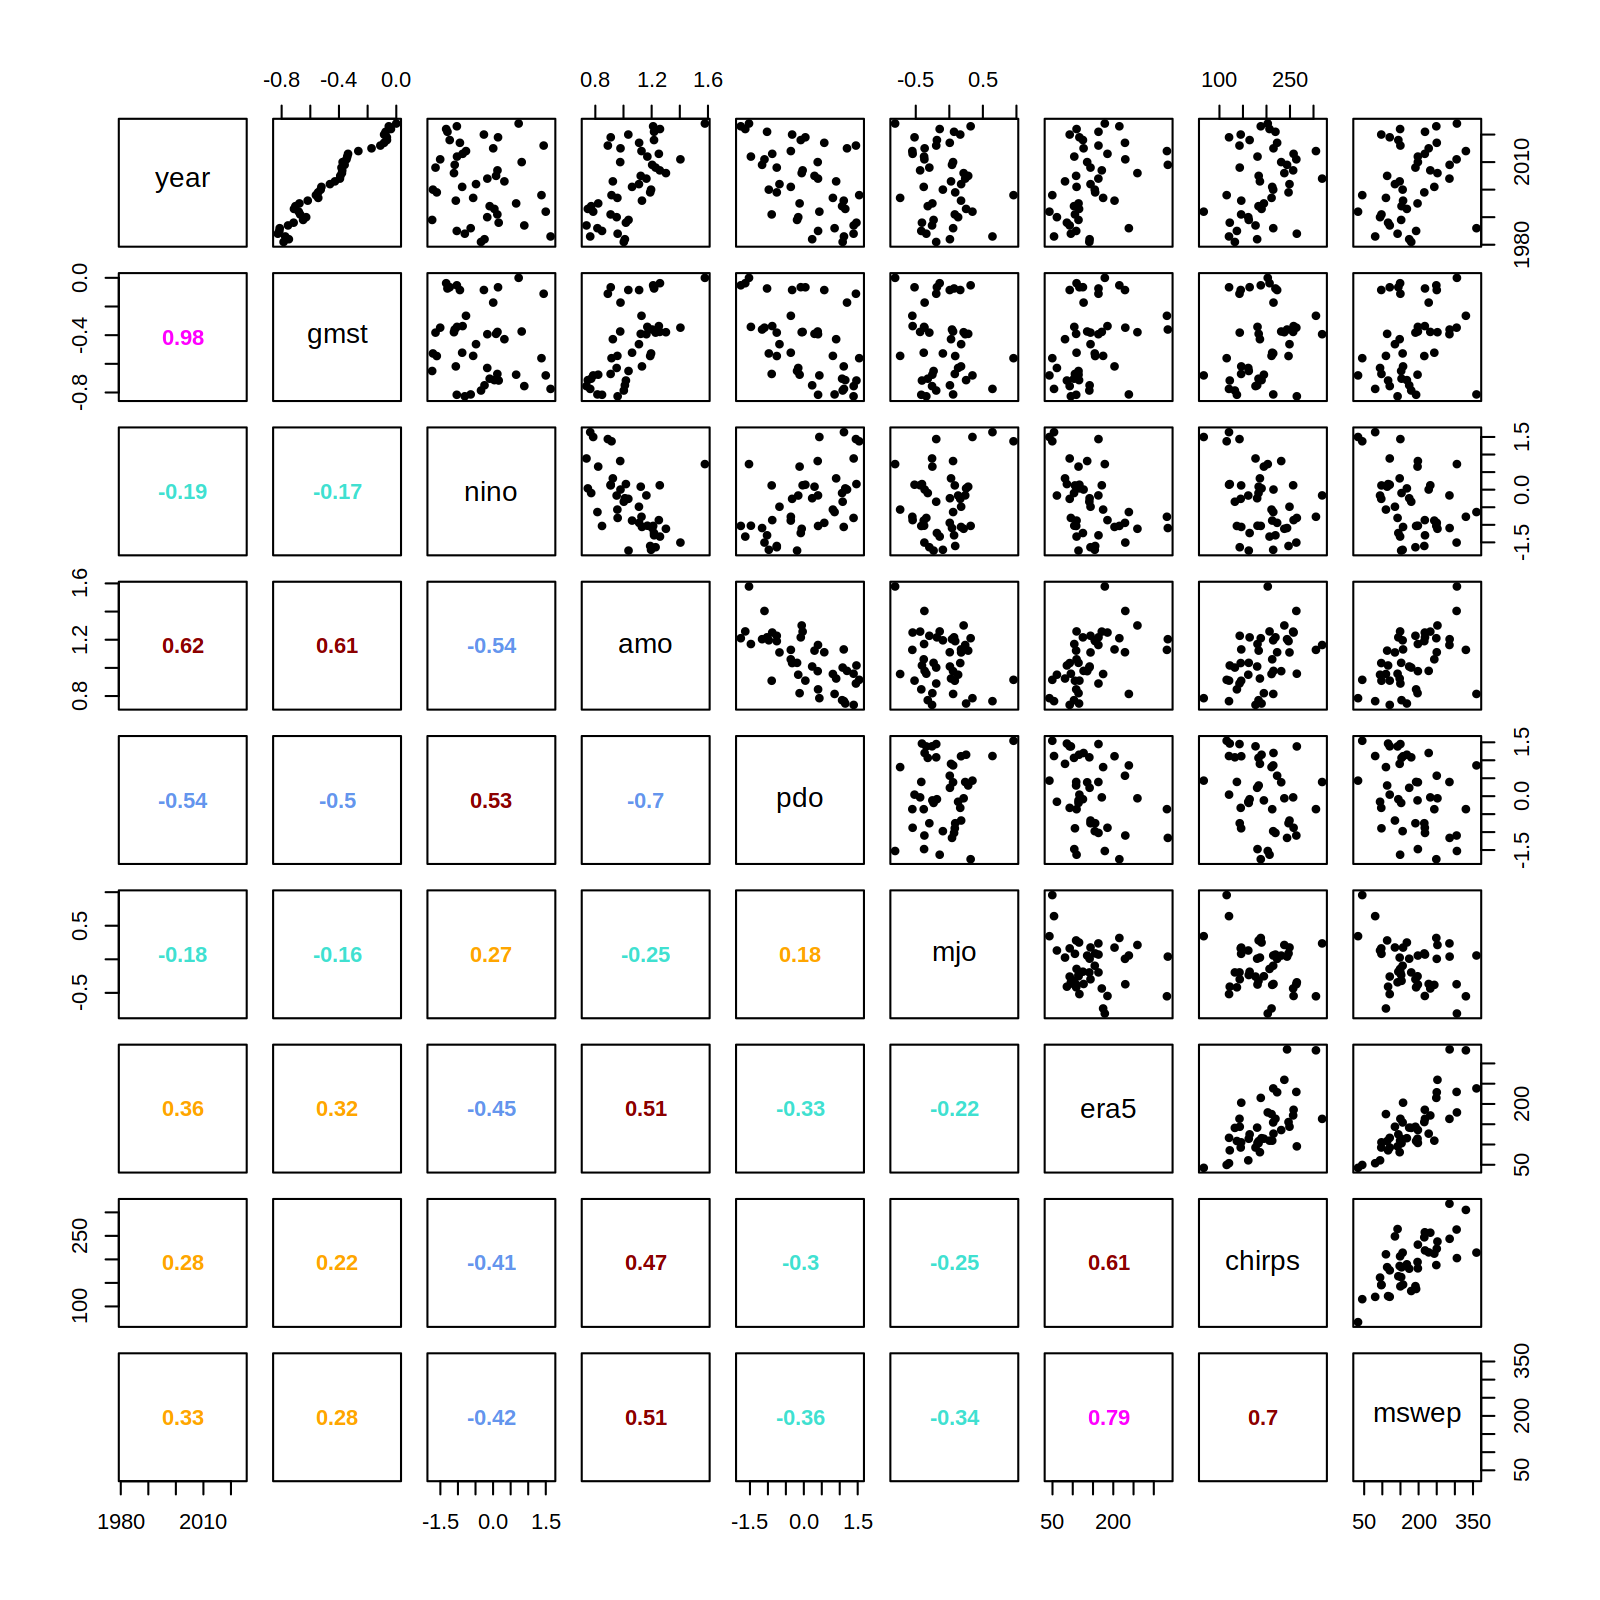

In [4]:
prep_window(c(2,2))
pairs(df[df$year > 1980,], lower.panel = panel.cor)

## Fit models

In [5]:
# fit all models
models <- list("gmst" = sapply(datasets, function(ds) { fit_ns("gev", "fixeddisp", df[!is.na(df[,ds]),], ds, c("gmst")) }, simplify = F),
               "gmst+nino" = sapply(datasets, function(ds) { fit_ns("gev", "fixeddisp", df[!is.na(df[,ds]),], ds, c("gmst", "nino")) }, simplify = F),
               "gmst+amo" = sapply(datasets, function(ds) { fit_ns("gev", "fixeddisp", df[!is.na(df[,ds]),], ds, c("gmst", "amo")) }, simplify = F),
               "gmst+pdo" = sapply(datasets, function(ds) { fit_ns("gev", "fixeddisp", df[!is.na(df[,ds]),], ds, c("gmst", "pdo")) }, simplify = F),
               "gmst+mjo" = sapply(datasets, function(ds) { fit_ns("gev", "fixeddisp", df[!is.na(rowSums(df[,c(ds, "mjo")])),], ds, c("gmst", "mjo")) }, simplify = F))

In [6]:
# check model fit
do.call("rbind", lapply(models, function(m_list) sapply(m_list, aic)))

,mswep,chirps,era5
gmst,532.0999,479.5015,833.7468
gmst+nino,527.1494,475.1919,810.8571
gmst+amo,529.3195,475.0084,820.3302
gmst+pdo,532.0848,480.1384,824.5061
gmst+mjo,530.5234,479.9881,511.4197


In [7]:
prep_window(c(1,4)); par(mfrow = c(1,3))

for (m in c("nino", "amo", "pdo", "mjo")) {
    png(paste0("fig/trend-fit_scale_gmst+", m, ".png"), width = 360*4, height = 360*1); par(mfrow = c(1,3), cex.main = 1.4); {
    
        for(ds in datasets) {
        
            ds_df <- df[!is.na(df[,ds]),]
            plot_trend(models[[paste0("gmst+",m)]][[ds]], ylim = c(0,400), xlim = c(1950, 2024), main = ds)
        }
    }; dev.off()
}


In [8]:
# check model fit
do.call("rbind", lapply(models, function(m_list) sapply(m_list, aic)))

,mswep,chirps,era5
gmst,532.0999,479.5015,833.7468
gmst+nino,527.1494,475.1919,810.8571
gmst+amo,529.3195,475.0084,820.3302
gmst+pdo,532.0848,480.1384,824.5061
gmst+mjo,530.5234,479.9881,511.4197


In [9]:
# return period of event
do.call("rbind", lapply(models, function(m_list) sapply(m_list, function(m) return_period(m)[length(m$x)])))

,mswep,chirps,era5
gmst,8.862270,1.807386,2.724964
gmst+nino,37.136537,3.335273,9.087632
gmst+amo,3.060509,1.263078,1.233496
gmst+pdo,5.106349,1.627931,1.633443
gmst+mjo,3.014011,1.434414,1.335693


In [10]:
# probability ratio (attributable to GMST)
do.call("rbind", lapply(models, function(m_list) sapply(m_list, function(m) prob_ratio(m, cov = cov_2024, cov_cf = cov_hist))))

,mswep,chirps,era5
gmst,12.476750,2.896479,2.677952
gmst+nino,292.550090,4.336142,3.021738
gmst+amo,2.363874,1.167841,1.228694
gmst+pdo,2.959013,1.369417,2.327288
gmst+mjo,4.651650,2.153749,4.382971


In [11]:
# change in intensity
do.call("rbind", lapply(models, function(m_list) sapply(m_list, function(m) int_change(m, cov = cov_2024, cov_cf = cov_hist))))

,mswep,chirps,era5
gmst,86.50417,65.31807,81.20700
gmst+nino,83.87833,47.42100,45.08249
gmst+amo,86.24569,32.62543,78.89608
gmst+pdo,68.37961,33.16381,114.37899
gmst+mjo,132.49600,75.51115,197.14856


## Bootstrapped change in intensity for each mode of variability


In [12]:
# # slow to run, so commenting out to avoid unintended re-bootstrapping
# gmst_res <- sapply(models[["gmst"]], function(mdl) {
#     res_gmst <- boot_ci(mdl, nsamp = 500, cov = cov_2024, cov_cf = cov_hist, rp = 10)
# }, simplify = F)
# names(gmst_res) <- paste0(names(gmst_res), "_gmst")
# write.csv(gmst_res, paste0("bootci_gmst.csv"))

# nino_res <- sapply(models[["gmst+nino"]], function(mdl) {
#     res_gmst <- boot_ci(mdl, nsamp = 500, cov = cov_2024, cov_cf = cov_hist, rp = 10)
#     res_nino <- boot_ci(mdl, nsamp = 500, cov = cov_2024, cov_cf = cov_neut, rp = 10)[c("PR", "dI_rel"),]
#     rownames(res_nino) <- c("PR_nino", "dI_rel_nino")
#     rbind(res_gmst, res_nino)
# }, simplify = F)
# names(nino_res) <- paste0(names(nino_res), "_gmst+nino")
# write.csv(nino_res, paste0("bootci_gmst+nino.csv"))

# pdo_res <- sapply(models[["gmst+pdo"]], function(mdl) {
#     res_gmst <- boot_ci(mdl, nsamp = 500, cov = cov_2024, cov_cf = cov_hist, rp = 10)
#     res_pdo <- boot_ci(mdl, nsamp = 500, cov = cov_2024, cov_cf = cov_pdo, rp = 10)[c("PR", "dI_rel"),]
#     rownames(res_pdo) <- c("PR_pdo", "dI_rel_pdo")
#     rbind(res_gmst, res_pdo)
# }, simplify = F)
# names(pdo_res) <- paste0(names(pdo_res), "_gmst+pdo")
# write.csv(pdo_res, paste0("bootci_gmst+pdo.csv"))

# amo_res <- sapply(models[["gmst+amo"]], function(mdl) {
#     res_gmst <- boot_ci(mdl, nsamp = 500, cov = cov_2024, cov_cf = cov_hist, rp = 10)
#     res_amo <- boot_ci(mdl, nsamp = 500, cov = cov_2024, cov_cf = cov_amo, rp = 10)[c("PR", "dI_rel"),]
#     rownames(res_amo) <- c("PR_amo", "dI_rel_amo")
#     rbind(res_gmst, res_amo)
# }, simplify = F)
# names(amo_res) <- paste0(names(amo_res), "_gmst+amo")
# write.csv(amo_res, paste0("bootci_gmst+amo.csv"))

# mjo_res <- sapply(models[["gmst+mjo"]], function(mdl) {
#     res_gmst <- boot_ci(mdl, nsamp = 500, cov = cov_2024, cov_cf = cov_hist, rp = 10)
#     res_mjo <- boot_ci(mdl, nsamp = 500, cov = cov_2024, cov_cf = cov_mjo, rp = 10)[c("PR", "dI_rel"),]
#     rownames(res_mjo) <- c("PR_mjo", "dI_rel_mjo")
#     rbind(res_gmst, res_mjo)
# }, simplify = F)
# names(mjo_res) <- paste0(names(mjo_res), "_gmst+mjo")
# write.csv(mjo_res, paste0("bootci_gmst+mjo.csv"))

In [13]:
res_tables <- sapply(c("alpha_gmst", "alpha_nino", "PR", "dI_rel", "PR_nino", "dI_rel_nino", "PR_pdo", "dI_rel_pdo", "PR_amo", "dI_rel_amo", "PR_mjo", "dI_rel_mjo"), function(r) {
    cbind(sapply(gmst_res, function(res) {
        if (r %in% rownames(res)) { return(res[r,]) } else { return(setNames(as.numeric(rep(NA, ncol(res))), c("bestimate", "2.5%", "97.5%"))) }
    }, simplify = T),
    sapply(nino_res, function(res) {
        if (r %in% rownames(res)) { return(res[r,]) } else { return(setNames(as.numeric(rep(NA, ncol(res))), c("bestimate", "2.5%", "97.5%"))) }
    }, simplify = T),
    sapply(pdo_res, function(res) {
        if (r %in% rownames(res)) { return(res[r,]) } else { return(setNames(as.numeric(rep(NA, ncol(res))), c("bestimate", "2.5%", "97.5%"))) }
    }, simplify = T),
    sapply(amo_res, function(res) {
        if (r %in% rownames(res)) { return(res[r,]) } else { return(setNames(as.numeric(rep(NA, ncol(res))), c("bestimate", "2.5%", "97.5%"))) }
    }, simplify = T),
    sapply(mjo_res, function(res) {
        if (r %in% rownames(res)) { return(res[r,]) } else { return(setNames(as.numeric(rep(NA, ncol(res))), c("bestimate", "2.5%", "97.5%"))) }
    }, simplify = T))
}, simplify = F)

for (r in c("dI_rel", "dI_rel_nino", "dI_rel_pdo", "dI_rel_mjo")) {
    write.csv(res_tables[[r]], paste0("bootci_",r,".csv"))
}

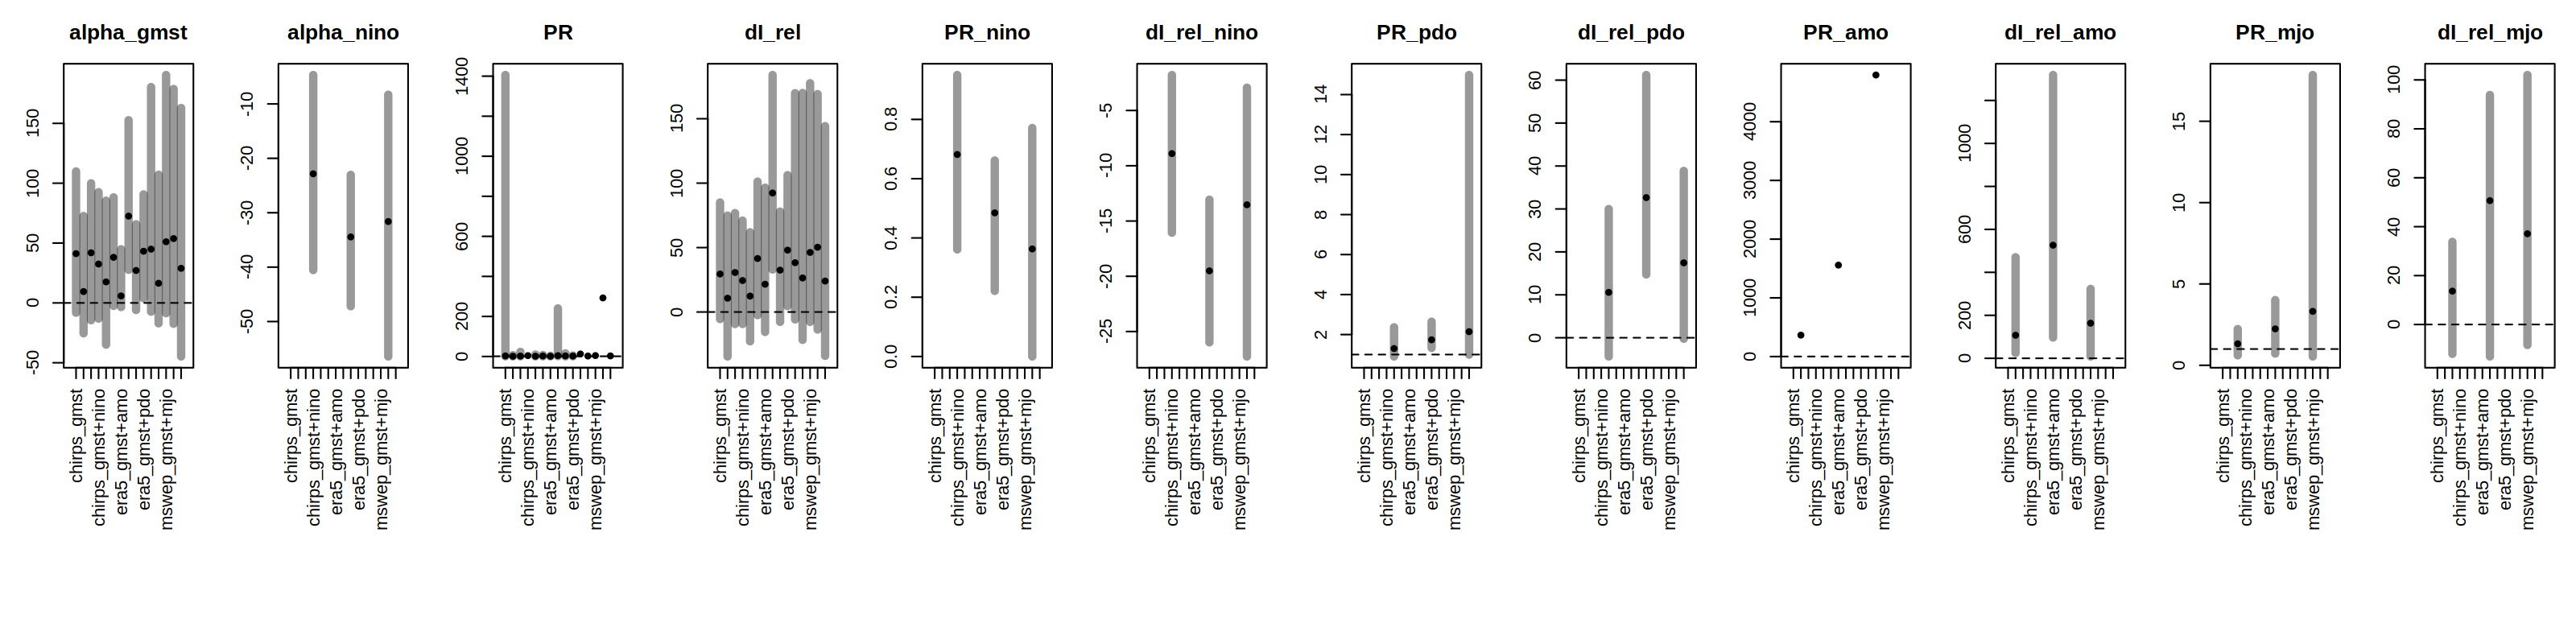

In [14]:
prep_window(c(1,4)); par(mfrow = c(1,length(res_tables)), mar = c(13,3,3,1))

for (r in names(res_tables)) {
    res <- res_tables[[r]]
    res <- res[,order(colnames(res))]
    res[!is.finite(res)] <- NA
    n <- ncol(res)
    
    plot(0, type = "n", ylim = range(res, na.rm = T), xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "")
    axis(1, at = 1:n, labels = colnames(res), las = 2)
    segments(x0 = 1:n, y0 = res["2.5%",], y1 = res["97.5%",], lwd = 5, col = adjustcolor("black", alpha = 0.4))
    points(1:n, res["bestimate",], pch = 20)
    if (grepl("PR", r)) { l = 1 } else { l = 0 }
    abline(h = l, lty = 2)
}

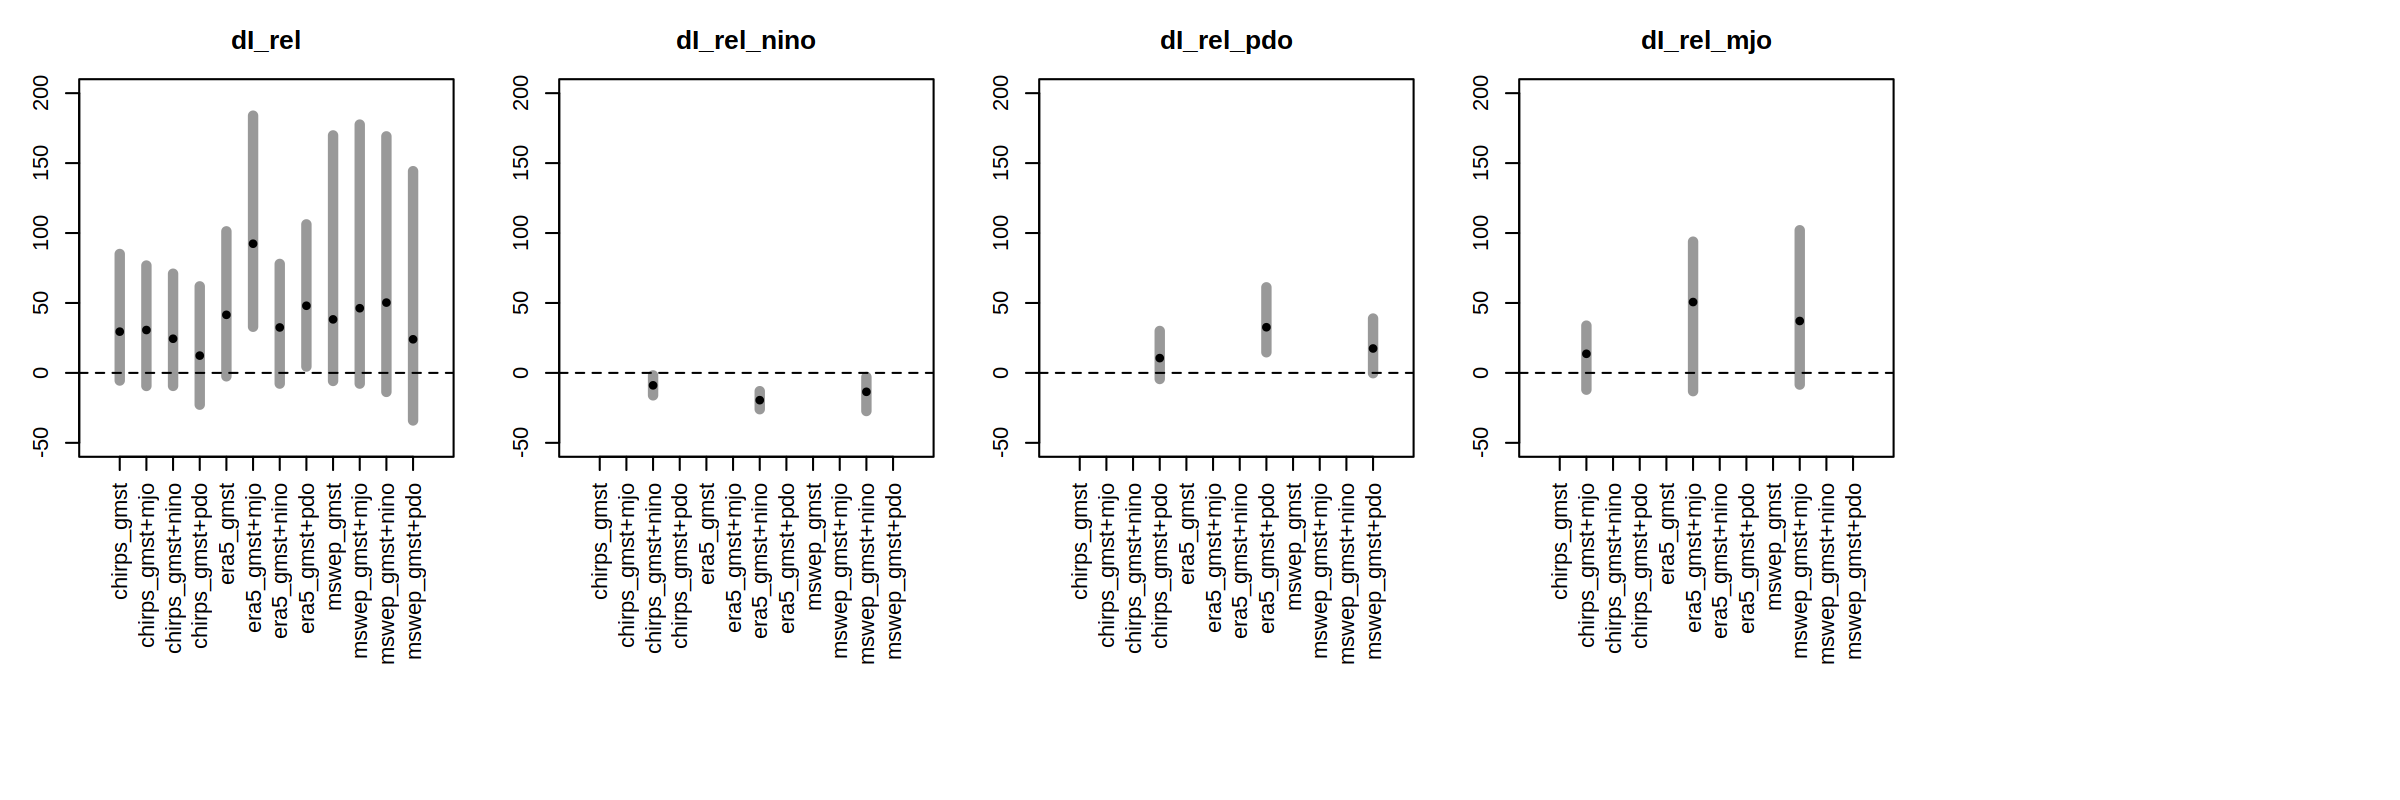

In [15]:
prep_window(c(1,3)); par(mfrow = c(1,sum(grepl("dI_rel", names(res_tables)))), mar = c(13,3,3,1))

for (r in names(res_tables)[grepl("dI_rel", names(res_tables))][-4]) {
    res <- res_tables[[r]]
    res <- res[,order(colnames(res))]
    res <- res[,!grepl("amo", colnames(res))]
    res[!is.finite(res)] <- NA
    n <- ncol(res)
    
    plot(0, type = "n", ylim = c(-50,200), xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "")
    axis(1, at = 1:n, labels = colnames(res), las = 2)
    segments(x0 = 1:n, y0 = res["2.5%",], y1 = res["97.5%",], lwd = 5, col = adjustcolor("black", alpha = 0.4))
    points(1:n, res["bestimate",], pch = 20)
    if (grepl("PR", r)) { l = 1 } else { l = 0 }
    abline(h = l, lty = 2)
}

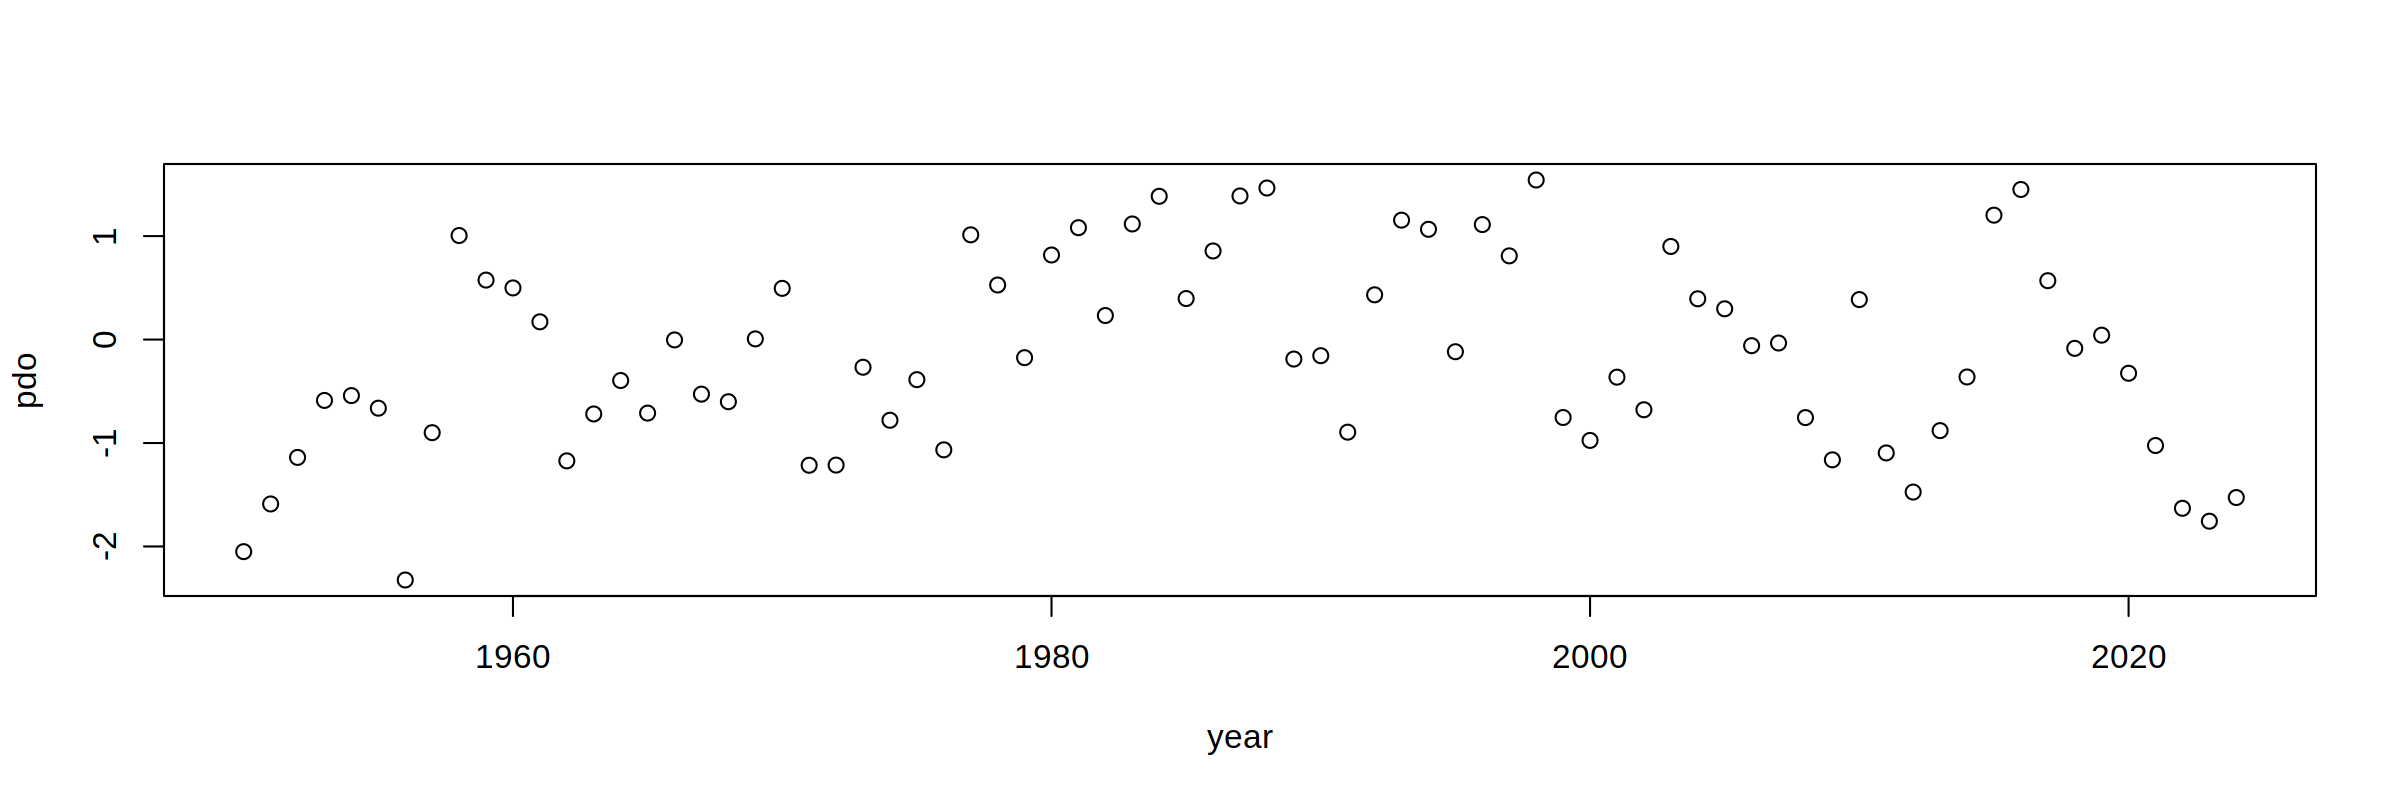

In [20]:
plot(pdo)